# Flower Recognition with ResNet

In [3]:
# Flower Recognition with ResNet - Complete Implementation
# Installing required packages
!pip install torch torchvision pandas numpy matplotlib scikit-learn pillow scipy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, classification_report
import scipy
from PIL import Image
import os
import shutil
import time
from tempfile import TemporaryDirectory
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cpu
Using device: cpu


In [4]:
# Set up data loading and preprocessing
import os
import scipy.io
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Data directories
data_dir = 'data/flowers-102'
images_dir = os.path.join(data_dir, 'jpg')

# Load mat files for labels and train/val/test splits
labels = scipy.io.loadmat(os.path.join(data_dir, 'imagelabels.mat'))['labels'][0] - 1  # Convert to 0-based indexing
splits = scipy.io.loadmat(os.path.join(data_dir, 'setid.mat'))

# Get indices for train, val, and test sets
train_idx = splits['trnid'][0] - 1  # Convert to 0-based indexing
val_idx = splits['valid'][0] - 1
test_idx = splits['tstid'][0] - 1

class Flowers102Dataset(Dataset):
    def __init__(self, image_dir, indices, labels, transform=None):
        self.image_dir = image_dir
        self.indices = indices
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_idx = self.indices[idx]
        img_name = f'image_{img_idx+1:05d}.jpg'
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        label = self.labels[img_idx]
        return image, label

# Define transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = Flowers102Dataset(images_dir, train_idx, labels, train_transform)
val_dataset = Flowers102Dataset(images_dir, val_idx, labels, val_test_transform)
test_dataset = Flowers102Dataset(images_dir, test_idx, labels, val_test_transform)

# Create dataloaders
batch_size = 32
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

# Store dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

print(f"Dataset sizes:")
print(f"Training: {dataset_sizes['train']} images")
print(f"Validation: {dataset_sizes['val']} images")
print(f"Test: {dataset_sizes['test']} images")

Dataset sizes:
Training: 1020 images
Validation: 1020 images
Test: 6149 images


Training samples:


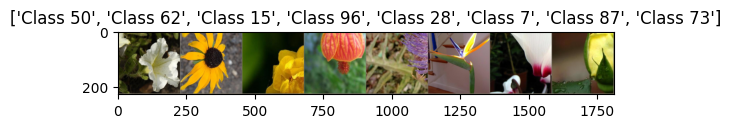

In [5]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Visualize some training images
def visualize_samples(dataloader, num_images=8):
    inputs, classes = next(iter(dataloader))
    out = torchvision.utils.make_grid(inputs[:num_images])
    imshow(out, title=[f'Class {x}' for x in classes[:num_images]])

print("Training samples:")
visualize_samples(dataloaders['train'])

In [15]:
# Base ResNet Model
class FlowerResNet(nn.Module):
    def __init__(self, base_model='resnet18', pretrained=True, num_classes=102):
        super(FlowerResNet, self).__init__()
        
        if base_model == 'resnet18':
            if pretrained:
                self.backbone = models.resnet18(weights='IMAGENET1K_V1')
            else:
                self.backbone = models.resnet18(weights=None)
        elif base_model == 'resnet34':
            if pretrained:
                self.backbone = models.resnet34(weights='IMAGENET1K_V1')
            else:
                self.backbone = models.resnet34(weights=None)
        else:
            raise ValueError("Unsupported base model")
        
        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.backbone(x)

# Model with Frozen Stages
class FlowerResNetFrozen(nn.Module):
    def __init__(self, base_model='resnet18', num_frozen_stages=3, num_classes=102):
        super(FlowerResNetFrozen, self).__init__()
        
        if base_model == 'resnet18':
            self.backbone = models.resnet18(weights='IMAGENET1K_V1')
        elif base_model == 'resnet34':
            self.backbone = models.resnet34(weights='IMAGENET1K_V1')
        else:
            raise ValueError("Unsupported base model")
        
        # Freeze specified stages
        self._freeze_stages(num_frozen_stages)
        
        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)
        
    def _freeze_stages(self, num_stages):
        """Freeze the first num_stages of ResNet"""
        if num_stages >= 1:
            for param in self.backbone.conv1.parameters():
                param.requires_grad = False
            for param in self.backbone.bn1.parameters():
                param.requires_grad = False
        if num_stages >= 2:
            for param in self.backbone.layer1.parameters():
                param.requires_grad = False
        if num_stages >= 3:
            for param in self.backbone.layer2.parameters():
                param.requires_grad = False
        if num_stages >= 4:
            for param in self.backbone.layer3.parameters():
                param.requires_grad = False
        if num_stages >= 5:
            for param in self.backbone.layer4.parameters():
                param.requires_grad = False
                
    def forward(self, x):
        return self.backbone(x)

# Deformable Convolution Implementation
class DeformableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DeformableConv2d, self).__init__()
        
        # Offset convolution
        self.offset_conv = nn.Conv2d(
            in_channels, 
            2 * kernel_size * kernel_size,
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding
        )
        
        # Regular convolution
        self.conv = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding
        )
        
        self.kernel_size = kernel_size
        
    def forward(self, x):
        # Generate offsets (simplified implementation)
        try:
            from torchvision.ops import deform_conv2d
            return deform_conv2d(x, offsets, self.conv.weight, self.conv.bias, 
                            stride=self.conv.stride, padding=self.conv.padding)
        except ImportError:
            # Fallback: at least use the offsets somehow, or just regular conv
            return self.conv(x)

# ResNet with Deformable Convolutions
class FlowerResNetDeformable(nn.Module):
    def __init__(self, base_model='resnet18', deform_layers=['layer3'], num_classes=102):
        super(FlowerResNetDeformable, self).__init__()
        
        if base_model == 'resnet18':
            self.backbone = models.resnet18(weights='IMAGENET1K_V1')
        else:
            raise ValueError("Only resnet18 supported for deformable version")
        
        # Replace regular convolutions with deformable ones in specified layers
        self._replace_with_deformable_conv(deform_layers)
        
        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)
        
    def _replace_with_deformable_conv(self, deform_layers):
        """Replace regular convolutions with deformable convolutions in specified layers"""
        layers_dict = {
            'layer1': self.backbone.layer1,
            'layer2': self.backbone.layer2,
            'layer3': self.backbone.layer3,
            'layer4': self.backbone.layer4
        }
        
        for layer_name in deform_layers:
            if layer_name in layers_dict:
                layer = layers_dict[layer_name]
                for block_idx, block in enumerate(layer):
                    # Replace 3x3 convolutions in each basic block
                    if hasattr(block, 'conv1') and block.conv1.kernel_size == (3, 3):
                        in_channels = block.conv1.in_channels
                        out_channels = block.conv1.out_channels
                        block.conv1 = DeformableConv2d(in_channels, out_channels)
                        
                    if hasattr(block, 'conv2') and block.conv2.kernel_size == (3, 3):
                        in_channels = block.conv2.in_channels
                        out_channels = block.conv2.out_channels
                        block.conv2 = DeformableConv2d(in_channels, out_channels)
    
    def forward(self, x):
        return self.backbone(x)

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, model_name='resnet18'):
    since = time.time()
    
    # Create checkpoint directory
    checkpoint_path = './model_checkpoints'
    os.makedirs(checkpoint_path, exist_ok=True)
    best_model_params_path = os.path.join(checkpoint_path, f'best_{model_name}_params.pt')
    
    # Save initial model
    torch.save(model.state_dict(), best_model_params_path)
    
    # Track metrics
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        
        # Each epoch has training and validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data with progress bar
            pbar = tqdm(dataloaders[phase], desc=f'{phase.capitalize()} Epoch {epoch}')
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update progress bar
                pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{torch.sum(preds == labels.data).item() / inputs.size(0):.4f}'
                })
            
            if phase == 'train' and scheduler is not None:
                scheduler.step()
            
            # Calculate epoch metrics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Store metrics
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.cpu())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.cpu())
            
            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)
                print(f'New best model saved with val_acc: {best_acc:.4f}')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(torch.load(best_model_params_path))
    
    return model, train_losses, train_accs, val_losses, val_accs

In [8]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.set_title(f'{model_name} - Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(train_accs, label='Train Acc')
    ax2.plot(val_accs, label='Val Acc')
    ax2.set_title(f'{model_name} - Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

def visualize_model_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 8))

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                
                # Color code correct/incorrect predictions
                color = 'green' if preds[j] == labels[j] else 'red'
                ax.set_title(f'Pred: {preds[j].item()} | True: {labels[j].item()}',
                           color=color, fontweight='bold')
                
                # Denormalize and show image
                inp = inputs.cpu().data[j]
                inp = inp.numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                ax.imshow(inp)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

def evaluate_model(model, criterion):
    was_training = model.training
    model.eval()
    
    test_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []
    
    print("Evaluating on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            correct += torch.sum(preds == labels.data)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss /= dataset_sizes['test']
    test_acc = correct.double() / dataset_sizes['test']
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')
    
    model.train(mode=was_training)
    return test_loss, test_acc, all_preds, all_labels

def plot_confusion_matrix(all_labels, all_preds, class_names=None):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_names if class_names else range(102),
                yticklabels=class_names if class_names else range(102))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/UG/rishika004/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 275MB/s]



Model architecture:
backbone.layer4.0.conv1.weight: torch.Size([512, 256, 3, 3])
backbone.layer4.0.bn1.weight: torch.Size([512])
backbone.layer4.0.bn1.bias: torch.Size([512])
backbone.layer4.0.conv2.weight: torch.Size([512, 512, 3, 3])
backbone.layer4.0.bn2.weight: torch.Size([512])
backbone.layer4.0.bn2.bias: torch.Size([512])
backbone.layer4.0.downsample.0.weight: torch.Size([512, 256, 1, 1])
backbone.layer4.0.downsample.1.weight: torch.Size([512])
backbone.layer4.0.downsample.1.bias: torch.Size([512])
backbone.layer4.1.conv1.weight: torch.Size([512, 512, 3, 3])
backbone.layer4.1.bn1.weight: torch.Size([512])
backbone.layer4.1.bn1.bias: torch.Size([512])
backbone.layer4.1.conv2.weight: torch.Size([512, 512, 3, 3])
backbone.layer4.1.bn2.weight: torch.Size([512])
backbone.layer4.1.bn2.bias: torch.Size([512])
backbone.fc.weight: torch.Size([102, 512])
backbone.fc.bias: torch.Size([102])
Epoch 0/49
----------
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 32/32 [00:24<00:00,  1.33it/s, Loss=4.5855, Acc=0.0357]


train Loss: 4.6938 Acc: 0.0147


Val Epoch 0: 100%|██████████| 32/32 [00:07<00:00,  4.56it/s, Loss=4.2075, Acc=0.1429]



val Loss: 4.3728 Acc: 0.0804
New best model saved with val_acc: 0.0804

Epoch 1/49
----------
New best model saved with val_acc: 0.0804

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 32/32 [00:14<00:00,  2.21it/s, Loss=3.8780, Acc=0.2857]


train Loss: 4.2212 Acc: 0.1206


Val Epoch 1: 100%|██████████| 32/32 [00:04<00:00,  7.41it/s, Loss=3.4918, Acc=0.4643]



val Loss: 3.8982 Acc: 0.2588
New best model saved with val_acc: 0.2588

Epoch 2/49
----------
New best model saved with val_acc: 0.2588

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s, Loss=3.4896, Acc=0.4286]


train Loss: 3.7541 Acc: 0.3216


Val Epoch 2: 100%|██████████| 32/32 [00:04<00:00,  7.58it/s, Loss=2.8661, Acc=0.6786]



val Loss: 3.3844 Acc: 0.4510
New best model saved with val_acc: 0.4510

Epoch 3/49
----------
New best model saved with val_acc: 0.4510

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s, Loss=2.8084, Acc=0.5714]


train Loss: 3.2675 Acc: 0.4980


Val Epoch 3: 100%|██████████| 32/32 [00:04<00:00,  7.44it/s, Loss=2.1523, Acc=0.8929]



val Loss: 2.8553 Acc: 0.5618
New best model saved with val_acc: 0.5618

Epoch 4/49
----------
New best model saved with val_acc: 0.5618

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s, Loss=2.8464, Acc=0.5714]


train Loss: 2.8044 Acc: 0.6088


Val Epoch 4: 100%|██████████| 32/32 [00:04<00:00,  7.41it/s, Loss=1.6883, Acc=0.9643]



val Loss: 2.4634 Acc: 0.6363
New best model saved with val_acc: 0.6363

Epoch 5/49
----------
New best model saved with val_acc: 0.6363

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s, Loss=2.3858, Acc=0.6786]


train Loss: 2.4319 Acc: 0.6892


Val Epoch 5: 100%|██████████| 32/32 [00:04<00:00,  7.85it/s, Loss=1.2651, Acc=0.9643]



val Loss: 2.0758 Acc: 0.6941
New best model saved with val_acc: 0.6941

Epoch 6/49
----------
New best model saved with val_acc: 0.6941

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 32/32 [00:11<00:00,  2.81it/s, Loss=1.8713, Acc=0.8571]


train Loss: 2.1545 Acc: 0.7196


Val Epoch 6: 100%|██████████| 32/32 [00:04<00:00,  7.55it/s, Loss=1.1191, Acc=0.9643]



val Loss: 1.7987 Acc: 0.7304
New best model saved with val_acc: 0.7304

Epoch 7/49
----------
New best model saved with val_acc: 0.7304

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 32/32 [00:10<00:00,  2.94it/s, Loss=2.1714, Acc=0.7143]


train Loss: 1.8906 Acc: 0.7608


Val Epoch 7: 100%|██████████| 32/32 [00:04<00:00,  7.59it/s, Loss=0.9530, Acc=0.9286]



val Loss: 1.5824 Acc: 0.7559
New best model saved with val_acc: 0.7559

Epoch 8/49
----------
New best model saved with val_acc: 0.7559

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 32/32 [00:11<00:00,  2.82it/s, Loss=1.3070, Acc=0.8929]


train Loss: 1.6476 Acc: 0.8010


Val Epoch 8: 100%|██████████| 32/32 [00:04<00:00,  7.38it/s, Loss=0.8683, Acc=0.9643]



val Loss: 1.4041 Acc: 0.7912
New best model saved with val_acc: 0.7912

Epoch 9/49
----------
New best model saved with val_acc: 0.7912

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s, Loss=1.6843, Acc=0.7500]


train Loss: 1.4937 Acc: 0.8265


Val Epoch 9: 100%|██████████| 32/32 [00:03<00:00,  8.03it/s, Loss=0.6208, Acc=1.0000]



val Loss: 1.2803 Acc: 0.8049
New best model saved with val_acc: 0.8049

Epoch 10/49
----------
New best model saved with val_acc: 0.8049

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 32/32 [00:11<00:00,  2.76it/s, Loss=1.2411, Acc=0.8929]


train Loss: 1.3188 Acc: 0.8510


Val Epoch 10: 100%|██████████| 32/32 [00:04<00:00,  7.97it/s, Loss=0.6603, Acc=0.9643]



val Loss: 1.1605 Acc: 0.8245
New best model saved with val_acc: 0.8245

Epoch 11/49
----------
New best model saved with val_acc: 0.8245

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s, Loss=1.1104, Acc=0.8214]


train Loss: 1.1799 Acc: 0.8804


Val Epoch 11: 100%|██████████| 32/32 [00:04<00:00,  7.71it/s, Loss=0.5977, Acc=0.9286]



val Loss: 1.0346 Acc: 0.8343
New best model saved with val_acc: 0.8343

Epoch 12/49
----------
New best model saved with val_acc: 0.8343

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s, Loss=1.0787, Acc=0.8571]


train Loss: 1.0743 Acc: 0.8784


Val Epoch 12: 100%|██████████| 32/32 [00:04<00:00,  7.56it/s, Loss=0.6188, Acc=0.9286]



val Loss: 0.9809 Acc: 0.8471
New best model saved with val_acc: 0.8471

Epoch 13/49
----------
New best model saved with val_acc: 0.8471

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 32/32 [00:10<00:00,  2.97it/s, Loss=1.1673, Acc=0.8571]


train Loss: 0.9906 Acc: 0.8765


Val Epoch 13: 100%|██████████| 32/32 [00:04<00:00,  7.45it/s, Loss=0.5340, Acc=0.9643]



val Loss: 0.9082 Acc: 0.8490
New best model saved with val_acc: 0.8490

Epoch 14/49
----------
New best model saved with val_acc: 0.8490

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s, Loss=0.8626, Acc=0.8571]


train Loss: 0.8667 Acc: 0.8990


Val Epoch 14: 100%|██████████| 32/32 [00:04<00:00,  7.70it/s, Loss=0.4701, Acc=0.9643]



val Loss: 0.8374 Acc: 0.8618
New best model saved with val_acc: 0.8618

Epoch 15/49
----------
New best model saved with val_acc: 0.8618

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s, Loss=0.9109, Acc=0.8929]


train Loss: 0.8323 Acc: 0.9010


Val Epoch 15: 100%|██████████| 32/32 [00:04<00:00,  7.51it/s, Loss=0.4278, Acc=0.9643]


val Loss: 0.8056 Acc: 0.8588

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s, Loss=0.8714, Acc=0.9286]


train Loss: 0.7677 Acc: 0.9235


Val Epoch 16: 100%|██████████| 32/32 [00:04<00:00,  7.46it/s, Loss=0.3741, Acc=0.9643]



val Loss: 0.7662 Acc: 0.8706
New best model saved with val_acc: 0.8706

Epoch 17/49
----------
New best model saved with val_acc: 0.8706

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s, Loss=0.9215, Acc=0.8571]


train Loss: 0.7063 Acc: 0.9275


Val Epoch 17: 100%|██████████| 32/32 [00:04<00:00,  7.93it/s, Loss=0.4086, Acc=0.9643]


val Loss: 0.7404 Acc: 0.8706

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 32/32 [00:10<00:00,  2.97it/s, Loss=0.5809, Acc=0.9643]


train Loss: 0.6473 Acc: 0.9245


Val Epoch 18: 100%|██████████| 32/32 [00:04<00:00,  7.72it/s, Loss=0.3865, Acc=0.9643]



val Loss: 0.6787 Acc: 0.8794
New best model saved with val_acc: 0.8794

Epoch 19/49
----------
New best model saved with val_acc: 0.8794

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 32/32 [00:10<00:00,  2.94it/s, Loss=0.6894, Acc=0.8929]


train Loss: 0.6139 Acc: 0.9343


Val Epoch 19: 100%|██████████| 32/32 [00:04<00:00,  7.79it/s, Loss=0.3731, Acc=0.9643]



val Loss: 0.6663 Acc: 0.8833
New best model saved with val_acc: 0.8833

Epoch 20/49
----------
New best model saved with val_acc: 0.8833

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 32/32 [00:11<00:00,  2.84it/s, Loss=0.6985, Acc=0.9286]


train Loss: 0.5967 Acc: 0.9333


Val Epoch 20: 100%|██████████| 32/32 [00:04<00:00,  7.71it/s, Loss=0.4130, Acc=0.9643]



val Loss: 0.6256 Acc: 0.8941
New best model saved with val_acc: 0.8941

Epoch 21/49
----------
New best model saved with val_acc: 0.8941

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 32/32 [00:12<00:00,  2.63it/s, Loss=0.8496, Acc=0.8929]


train Loss: 0.5684 Acc: 0.9363


Val Epoch 21: 100%|██████████| 32/32 [00:04<00:00,  7.26it/s, Loss=0.3658, Acc=0.9643]



val Loss: 0.6056 Acc: 0.9020
New best model saved with val_acc: 0.9020

Epoch 22/49
----------
New best model saved with val_acc: 0.9020

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 32/32 [00:10<00:00,  2.96it/s, Loss=0.8169, Acc=0.8929]


train Loss: 0.5465 Acc: 0.9333


Val Epoch 22: 100%|██████████| 32/32 [00:04<00:00,  7.41it/s, Loss=0.2421, Acc=0.9643]


val Loss: 0.5962 Acc: 0.8931

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s, Loss=0.6412, Acc=0.9286]


train Loss: 0.5007 Acc: 0.9333


Val Epoch 23: 100%|██████████| 32/32 [00:05<00:00,  6.31it/s, Loss=0.2484, Acc=0.9643]


val Loss: 0.5748 Acc: 0.8941

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s, Loss=0.5082, Acc=0.9286]


train Loss: 0.4760 Acc: 0.9392


Val Epoch 24: 100%|██████████| 32/32 [00:04<00:00,  7.51it/s, Loss=0.2328, Acc=0.9643]


val Loss: 0.5561 Acc: 0.8882

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s, Loss=0.4205, Acc=0.9286]


train Loss: 0.4367 Acc: 0.9500


Val Epoch 25: 100%|██████████| 32/32 [00:04<00:00,  7.55it/s, Loss=0.2750, Acc=0.9643]


val Loss: 0.5413 Acc: 0.9000

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 32/32 [00:11<00:00,  2.86it/s, Loss=0.7200, Acc=0.8929]


train Loss: 0.4248 Acc: 0.9402


Val Epoch 26: 100%|██████████| 32/32 [00:04<00:00,  7.80it/s, Loss=0.2236, Acc=0.9643]



val Loss: 0.5286 Acc: 0.9118
New best model saved with val_acc: 0.9118

Epoch 27/49
----------
New best model saved with val_acc: 0.9118

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s, Loss=0.4794, Acc=0.9286]


train Loss: 0.4364 Acc: 0.9480


Val Epoch 27: 100%|██████████| 32/32 [00:04<00:00,  7.56it/s, Loss=0.2698, Acc=0.9643]


val Loss: 0.5077 Acc: 0.9118

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s, Loss=0.3773, Acc=0.9286]


train Loss: 0.3801 Acc: 0.9559


Val Epoch 28: 100%|██████████| 32/32 [00:04<00:00,  7.76it/s, Loss=0.2306, Acc=0.9643]


val Loss: 0.5130 Acc: 0.9069

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s, Loss=0.4142, Acc=0.9286]


train Loss: 0.3979 Acc: 0.9461


Val Epoch 29: 100%|██████████| 32/32 [00:04<00:00,  7.81it/s, Loss=0.2236, Acc=0.9643]


val Loss: 0.5001 Acc: 0.9069

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s, Loss=0.2220, Acc=1.0000]


train Loss: 0.3322 Acc: 0.9618


Val Epoch 30: 100%|██████████| 32/32 [00:04<00:00,  7.41it/s, Loss=0.2118, Acc=0.9643]


val Loss: 0.4953 Acc: 0.9039

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s, Loss=0.2806, Acc=1.0000]


train Loss: 0.3269 Acc: 0.9647


Val Epoch 31: 100%|██████████| 32/32 [00:04<00:00,  7.58it/s, Loss=0.2100, Acc=0.9643]


val Loss: 0.4947 Acc: 0.9049

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s, Loss=0.2677, Acc=1.0000]


train Loss: 0.3251 Acc: 0.9657


Val Epoch 32: 100%|██████████| 32/32 [00:04<00:00,  7.86it/s, Loss=0.2198, Acc=0.9643]


val Loss: 0.4967 Acc: 0.9069

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 32/32 [00:11<00:00,  2.72it/s, Loss=0.4873, Acc=0.8214]


train Loss: 0.3640 Acc: 0.9588


Val Epoch 33: 100%|██████████| 32/32 [00:04<00:00,  7.70it/s, Loss=0.2345, Acc=0.9643]


val Loss: 0.4983 Acc: 0.9029

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s, Loss=0.1895, Acc=1.0000]


train Loss: 0.3153 Acc: 0.9637


Val Epoch 34: 100%|██████████| 32/32 [00:04<00:00,  7.42it/s, Loss=0.1992, Acc=0.9643]


val Loss: 0.4889 Acc: 0.9078

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s, Loss=0.2701, Acc=0.9643]


train Loss: 0.3264 Acc: 0.9696


Val Epoch 35: 100%|██████████| 32/32 [00:04<00:00,  7.71it/s, Loss=0.2056, Acc=0.9643]


val Loss: 0.4831 Acc: 0.9049

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s, Loss=0.3267, Acc=0.8929]


train Loss: 0.3090 Acc: 0.9637


Val Epoch 36: 100%|██████████| 32/32 [00:04<00:00,  7.52it/s, Loss=0.2143, Acc=0.9643]



val Loss: 0.4868 Acc: 0.9137
New best model saved with val_acc: 0.9137

Epoch 37/49
----------
New best model saved with val_acc: 0.9137

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 32/32 [00:14<00:00,  2.19it/s, Loss=0.2683, Acc=0.9643]


train Loss: 0.3301 Acc: 0.9627


Val Epoch 37: 100%|██████████| 32/32 [00:04<00:00,  7.58it/s, Loss=0.1938, Acc=0.9643]


val Loss: 0.4905 Acc: 0.9118

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s, Loss=0.3496, Acc=0.9643]


train Loss: 0.3400 Acc: 0.9559


Val Epoch 38: 100%|██████████| 32/32 [00:04<00:00,  7.38it/s, Loss=0.2061, Acc=0.9643]


val Loss: 0.4853 Acc: 0.9098

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s, Loss=0.2917, Acc=1.0000]


train Loss: 0.3258 Acc: 0.9647


Val Epoch 39: 100%|██████████| 32/32 [00:04<00:00,  7.33it/s, Loss=0.2148, Acc=0.9643]


val Loss: 0.4822 Acc: 0.9118

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 32/32 [00:12<00:00,  2.65it/s, Loss=0.2996, Acc=0.9286]


train Loss: 0.3195 Acc: 0.9608


Val Epoch 40: 100%|██████████| 32/32 [00:04<00:00,  7.20it/s, Loss=0.2393, Acc=0.9643]


val Loss: 0.4792 Acc: 0.9108

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s, Loss=0.2670, Acc=0.9286]


train Loss: 0.3284 Acc: 0.9549


Val Epoch 41: 100%|██████████| 32/32 [00:04<00:00,  7.75it/s, Loss=0.2170, Acc=0.9643]



val Loss: 0.4909 Acc: 0.9167
New best model saved with val_acc: 0.9167

Epoch 42/49
----------
New best model saved with val_acc: 0.9167

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 32/32 [00:17<00:00,  1.88it/s, Loss=0.6636, Acc=0.8929]


train Loss: 0.3364 Acc: 0.9627


Val Epoch 42: 100%|██████████| 32/32 [00:04<00:00,  7.36it/s, Loss=0.2282, Acc=0.9643]


val Loss: 0.4807 Acc: 0.9127

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 32/32 [00:11<00:00,  2.71it/s, Loss=0.2600, Acc=1.0000]


train Loss: 0.3194 Acc: 0.9667


Val Epoch 43: 100%|██████████| 32/32 [00:05<00:00,  5.52it/s, Loss=0.2272, Acc=0.9643]


val Loss: 0.4823 Acc: 0.9147

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s, Loss=0.4201, Acc=0.9643]


train Loss: 0.3309 Acc: 0.9676


Val Epoch 44: 100%|██████████| 32/32 [00:04<00:00,  7.45it/s, Loss=0.2285, Acc=0.9643]


val Loss: 0.4861 Acc: 0.9127

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s, Loss=0.3421, Acc=1.0000]


train Loss: 0.3269 Acc: 0.9598


Val Epoch 45: 100%|██████████| 32/32 [00:04<00:00,  7.66it/s, Loss=0.2302, Acc=0.9643]


val Loss: 0.4709 Acc: 0.9147

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s, Loss=0.3461, Acc=0.9643]


train Loss: 0.3388 Acc: 0.9588


Val Epoch 46: 100%|██████████| 32/32 [00:04<00:00,  7.37it/s, Loss=0.2267, Acc=0.9643]


val Loss: 0.4763 Acc: 0.9088

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s, Loss=0.3053, Acc=0.9643]


train Loss: 0.3355 Acc: 0.9618


Val Epoch 47: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s, Loss=0.1971, Acc=0.9643]


val Loss: 0.4680 Acc: 0.9108

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s, Loss=0.4291, Acc=0.9643]


train Loss: 0.3292 Acc: 0.9578


Val Epoch 48: 100%|██████████| 32/32 [00:04<00:00,  7.48it/s, Loss=0.2211, Acc=0.9643]


val Loss: 0.4813 Acc: 0.9118

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s, Loss=0.5421, Acc=0.8929]


train Loss: 0.3780 Acc: 0.9559


Val Epoch 49: 100%|██████████| 32/32 [00:04<00:00,  7.73it/s, Loss=0.2081, Acc=0.9643]



val Loss: 0.4751 Acc: 0.9118

Training complete in 13m 52s
Best val Acc: 0.916667


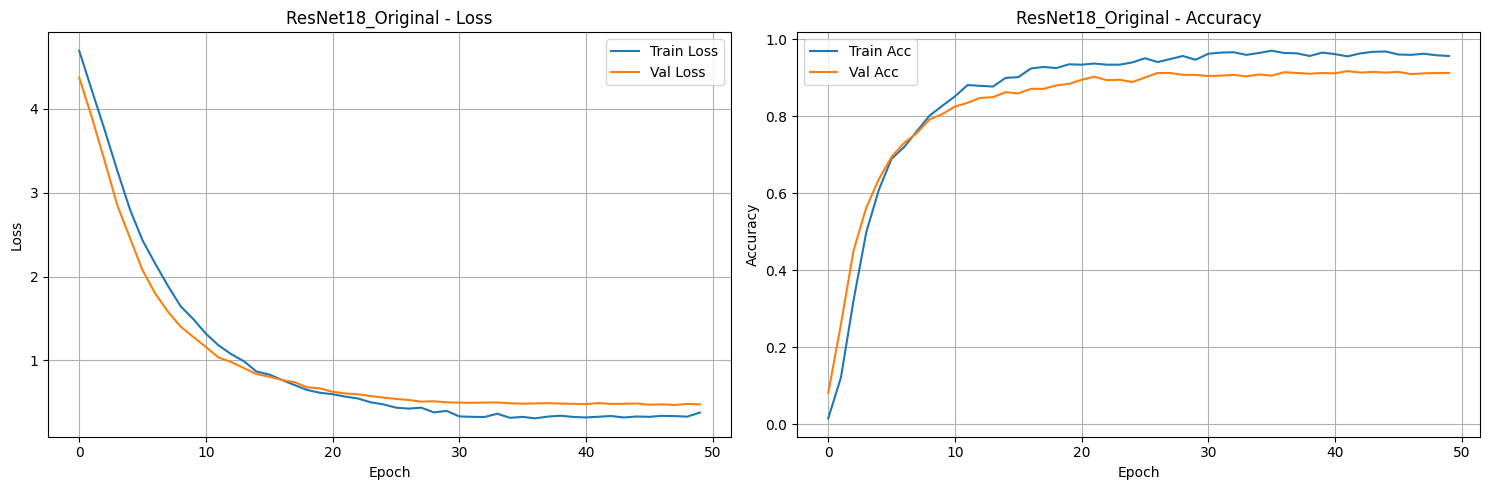

Evaluating on test set...


100%|██████████| 193/193 [00:37<00:00,  5.21it/s]

Test Loss: 0.5874
Test Accuracy: 0.8803
ResNet18 Original - Test Accuracy: 0.8803


In [9]:

# Create model
model_resnet18 = FlowerResNet(base_model='resnet18', pretrained=True, num_classes=102)
model_resnet18 = model_resnet18.to(device)

# Display model architecture
print("Model architecture:")
for name, param in model_resnet18.named_parameters():
    if "fc" in name or "layer4" in name:
        print(f"{name}: {param.shape}")

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet18.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Train model
num_epochs = 50
model_resnet18, train_losses, train_accs, val_losses, val_accs = train_model(
    model_resnet18, criterion, optimizer, scheduler, num_epochs, 'resnet18_original'
)

# Plot results
plot_training_curves(train_losses, val_losses, train_accs, val_accs, 'ResNet18_Original')

# Evaluate on test set
test_loss, test_acc, all_preds, all_labels = evaluate_model(model_resnet18, criterion)

# Save training logs
with open('resnet18_original.txt', 'w') as f:
    f.write("Epoch,Train_Loss,Val_Loss,Train_Acc,Val_Acc\n")
    for epoch in range(num_epochs):
        f.write(f"{epoch+1},{train_losses[epoch]:.4f},{val_losses[epoch]:.4f},{train_accs[epoch]:.4f},{val_accs[epoch]:.4f}\n")

print(f"ResNet18 Original - Test Accuracy: {test_acc:.4f}")

### Experiment 2 resnet-18 with 3 frozen stages

Trainable parameters: 10545766/11228838 (93.92%)
Epoch 0/49
----------
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 32/32 [00:07<00:00,  4.34it/s, Loss=4.5514, Acc=0.0357]


train Loss: 4.7557 Acc: 0.0157


Val Epoch 0: 100%|██████████| 32/32 [00:04<00:00,  7.25it/s, Loss=4.0162, Acc=0.1071]



val Loss: 4.4227 Acc: 0.0471
New best model saved with val_acc: 0.0471

Epoch 1/49
----------
New best model saved with val_acc: 0.0471

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s, Loss=4.2355, Acc=0.0714]


train Loss: 4.3051 Acc: 0.0745


Val Epoch 1: 100%|██████████| 32/32 [00:04<00:00,  7.64it/s, Loss=3.5237, Acc=0.4643]



val Loss: 3.9703 Acc: 0.2127
New best model saved with val_acc: 0.2127

Epoch 2/49
----------
New best model saved with val_acc: 0.2127

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 32/32 [00:07<00:00,  4.42it/s, Loss=3.7410, Acc=0.3214]


train Loss: 3.8614 Acc: 0.2892


Val Epoch 2: 100%|██████████| 32/32 [00:04<00:00,  7.36it/s, Loss=3.0009, Acc=0.7143]



val Loss: 3.4903 Acc: 0.4167
New best model saved with val_acc: 0.4167

Epoch 3/49
----------
New best model saved with val_acc: 0.4167

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 32/32 [00:06<00:00,  4.60it/s, Loss=2.9461, Acc=0.7857]


train Loss: 3.3898 Acc: 0.4725


Val Epoch 3: 100%|██████████| 32/32 [00:04<00:00,  7.75it/s, Loss=2.2624, Acc=0.9286]



val Loss: 3.0142 Acc: 0.5618
New best model saved with val_acc: 0.5618

Epoch 4/49
----------
New best model saved with val_acc: 0.5618

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 32/32 [00:06<00:00,  4.58it/s, Loss=2.8208, Acc=0.6071]


train Loss: 2.9682 Acc: 0.5941


Val Epoch 4: 100%|██████████| 32/32 [00:04<00:00,  7.47it/s, Loss=1.5881, Acc=0.9643]



val Loss: 2.5509 Acc: 0.6559
New best model saved with val_acc: 0.6559

Epoch 5/49
----------
New best model saved with val_acc: 0.6559

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 32/32 [00:07<00:00,  4.53it/s, Loss=2.2221, Acc=0.7857]


train Loss: 2.5911 Acc: 0.6902


Val Epoch 5: 100%|██████████| 32/32 [00:04<00:00,  7.61it/s, Loss=1.2846, Acc=0.9286]



val Loss: 2.1898 Acc: 0.7118
New best model saved with val_acc: 0.7118

Epoch 6/49
----------
New best model saved with val_acc: 0.7118

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 32/32 [00:07<00:00,  4.28it/s, Loss=1.8823, Acc=0.8571]


train Loss: 2.2331 Acc: 0.7284


Val Epoch 6: 100%|██████████| 32/32 [00:04<00:00,  7.44it/s, Loss=1.1438, Acc=0.9643]



val Loss: 1.8617 Acc: 0.7422
New best model saved with val_acc: 0.7422

Epoch 7/49
----------
New best model saved with val_acc: 0.7422

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s, Loss=2.0263, Acc=0.7143]


train Loss: 1.9834 Acc: 0.7873


Val Epoch 7: 100%|██████████| 32/32 [00:04<00:00,  7.57it/s, Loss=0.8998, Acc=0.9286]



val Loss: 1.6434 Acc: 0.7696
New best model saved with val_acc: 0.7696

Epoch 8/49
----------
New best model saved with val_acc: 0.7696

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 32/32 [00:07<00:00,  4.48it/s, Loss=1.6387, Acc=0.7143]


train Loss: 1.7492 Acc: 0.8029


Val Epoch 8: 100%|██████████| 32/32 [00:04<00:00,  7.92it/s, Loss=0.8151, Acc=0.9643]



val Loss: 1.4535 Acc: 0.7990
New best model saved with val_acc: 0.7990

Epoch 9/49
----------
New best model saved with val_acc: 0.7990

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 32/32 [00:06<00:00,  4.68it/s, Loss=1.9231, Acc=0.6786]


train Loss: 1.5483 Acc: 0.8225


Val Epoch 9: 100%|██████████| 32/32 [00:04<00:00,  7.44it/s, Loss=0.7577, Acc=1.0000]



val Loss: 1.3002 Acc: 0.8294
New best model saved with val_acc: 0.8294

Epoch 10/49
----------
New best model saved with val_acc: 0.8294

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 32/32 [00:07<00:00,  4.56it/s, Loss=1.5249, Acc=0.7857]


train Loss: 1.3600 Acc: 0.8578


Val Epoch 10: 100%|██████████| 32/32 [00:04<00:00,  7.61it/s, Loss=0.6224, Acc=1.0000]



val Loss: 1.1591 Acc: 0.8333
New best model saved with val_acc: 0.8333

Epoch 11/49
----------
New best model saved with val_acc: 0.8333

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s, Loss=1.0960, Acc=0.9286]


train Loss: 1.2313 Acc: 0.8765


Val Epoch 11: 100%|██████████| 32/32 [00:04<00:00,  7.61it/s, Loss=0.6187, Acc=1.0000]



val Loss: 1.0665 Acc: 0.8578
New best model saved with val_acc: 0.8578

Epoch 12/49
----------
New best model saved with val_acc: 0.8578

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 32/32 [00:07<00:00,  4.54it/s, Loss=0.8377, Acc=0.8929]


train Loss: 1.1440 Acc: 0.8696


Val Epoch 12: 100%|██████████| 32/32 [00:04<00:00,  7.52it/s, Loss=0.5764, Acc=0.9643]



val Loss: 0.9754 Acc: 0.8667
New best model saved with val_acc: 0.8667

Epoch 13/49
----------
New best model saved with val_acc: 0.8667

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s, Loss=1.0982, Acc=0.8214]


train Loss: 1.0235 Acc: 0.8941


Val Epoch 13: 100%|██████████| 32/32 [00:05<00:00,  6.37it/s, Loss=0.5339, Acc=1.0000]



val Loss: 0.8999 Acc: 0.8735
New best model saved with val_acc: 0.8735

Epoch 14/49
----------
New best model saved with val_acc: 0.8735

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 32/32 [00:07<00:00,  4.42it/s, Loss=0.9332, Acc=0.8929]


train Loss: 0.9164 Acc: 0.9039


Val Epoch 14: 100%|██████████| 32/32 [00:04<00:00,  7.04it/s, Loss=0.4161, Acc=0.9643]


val Loss: 0.8405 Acc: 0.8706

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s, Loss=0.8859, Acc=0.8929]


train Loss: 0.8396 Acc: 0.9127


Val Epoch 15: 100%|██████████| 32/32 [00:04<00:00,  7.84it/s, Loss=0.4744, Acc=0.9643]



val Loss: 0.7967 Acc: 0.8784
New best model saved with val_acc: 0.8784

Epoch 16/49
----------
New best model saved with val_acc: 0.8784

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 32/32 [00:07<00:00,  4.48it/s, Loss=0.9638, Acc=0.8929]


train Loss: 0.7821 Acc: 0.9118


Val Epoch 16: 100%|██████████| 32/32 [00:04<00:00,  7.78it/s, Loss=0.4264, Acc=0.9643]



val Loss: 0.7501 Acc: 0.8853
New best model saved with val_acc: 0.8853

Epoch 17/49
----------
New best model saved with val_acc: 0.8853

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 32/32 [00:10<00:00,  2.96it/s, Loss=0.6973, Acc=0.9286]


train Loss: 0.7031 Acc: 0.9314


Val Epoch 17: 100%|██████████| 32/32 [00:04<00:00,  7.60it/s, Loss=0.4329, Acc=0.9643]



val Loss: 0.7131 Acc: 0.8892
New best model saved with val_acc: 0.8892

Epoch 18/49
----------
New best model saved with val_acc: 0.8892

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s, Loss=0.4212, Acc=0.9643]


train Loss: 0.7313 Acc: 0.9069


Val Epoch 18: 100%|██████████| 32/32 [00:04<00:00,  7.79it/s, Loss=0.3518, Acc=0.9643]



val Loss: 0.6831 Acc: 0.8951
New best model saved with val_acc: 0.8951

Epoch 19/49
----------
New best model saved with val_acc: 0.8951

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 32/32 [00:07<00:00,  4.46it/s, Loss=0.7380, Acc=0.9643]


train Loss: 0.6680 Acc: 0.9216


Val Epoch 19: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s, Loss=0.3767, Acc=0.9643]



val Loss: 0.6557 Acc: 0.8971
New best model saved with val_acc: 0.8971

Epoch 20/49
----------
New best model saved with val_acc: 0.8971

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s, Loss=0.4197, Acc=1.0000]


train Loss: 0.6069 Acc: 0.9343


Val Epoch 20: 100%|██████████| 32/32 [00:04<00:00,  7.95it/s, Loss=0.3840, Acc=0.9643]


val Loss: 0.6238 Acc: 0.8961

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 32/32 [00:06<00:00,  4.58it/s, Loss=0.5089, Acc=0.9286]


train Loss: 0.5777 Acc: 0.9324


Val Epoch 21: 100%|██████████| 32/32 [00:04<00:00,  7.78it/s, Loss=0.3221, Acc=0.9643]


val Loss: 0.6149 Acc: 0.8961

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 32/32 [00:06<00:00,  4.71it/s, Loss=0.3690, Acc=0.9643]


train Loss: 0.5418 Acc: 0.9412


Val Epoch 22: 100%|██████████| 32/32 [00:04<00:00,  7.65it/s, Loss=0.3083, Acc=0.9643]



val Loss: 0.5821 Acc: 0.9039
New best model saved with val_acc: 0.9039

Epoch 23/49
----------
New best model saved with val_acc: 0.9039

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s, Loss=0.5589, Acc=0.8929]


train Loss: 0.5012 Acc: 0.9480


Val Epoch 23: 100%|██████████| 32/32 [00:04<00:00,  7.76it/s, Loss=0.3490, Acc=0.9643]



val Loss: 0.5640 Acc: 0.9088
New best model saved with val_acc: 0.9088

Epoch 24/49
----------
New best model saved with val_acc: 0.9088

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 32/32 [00:07<00:00,  4.56it/s, Loss=0.4844, Acc=0.9643]


train Loss: 0.4962 Acc: 0.9451


Val Epoch 24: 100%|██████████| 32/32 [00:04<00:00,  7.70it/s, Loss=0.3128, Acc=0.9643]


val Loss: 0.5514 Acc: 0.9039

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 32/32 [00:06<00:00,  4.83it/s, Loss=0.5100, Acc=0.9286]


train Loss: 0.4490 Acc: 0.9510


Val Epoch 25: 100%|██████████| 32/32 [00:04<00:00,  7.71it/s, Loss=0.3545, Acc=0.9643]


val Loss: 0.5397 Acc: 0.9078

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 32/32 [00:07<00:00,  4.37it/s, Loss=0.5672, Acc=0.9286]


train Loss: 0.4567 Acc: 0.9500


Val Epoch 26: 100%|██████████| 32/32 [00:04<00:00,  7.89it/s, Loss=0.3091, Acc=0.9643]



val Loss: 0.5229 Acc: 0.9108
New best model saved with val_acc: 0.9108

Epoch 27/49
----------
New best model saved with val_acc: 0.9108

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 32/32 [00:07<00:00,  4.50it/s, Loss=0.2683, Acc=0.9643]


train Loss: 0.4339 Acc: 0.9451


Val Epoch 27: 100%|██████████| 32/32 [00:04<00:00,  7.62it/s, Loss=0.2984, Acc=0.9643]


val Loss: 0.5114 Acc: 0.9098

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s, Loss=0.2684, Acc=1.0000]


train Loss: 0.4113 Acc: 0.9549


Val Epoch 28: 100%|██████████| 32/32 [00:04<00:00,  7.91it/s, Loss=0.2908, Acc=0.9643]



val Loss: 0.5002 Acc: 0.9118
New best model saved with val_acc: 0.9118

Epoch 29/49
----------
New best model saved with val_acc: 0.9118

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 32/32 [00:06<00:00,  4.63it/s, Loss=0.2921, Acc=1.0000]


train Loss: 0.3831 Acc: 0.9500


Val Epoch 29: 100%|██████████| 32/32 [00:04<00:00,  7.76it/s, Loss=0.3057, Acc=0.9643]



val Loss: 0.5010 Acc: 0.9127
New best model saved with val_acc: 0.9127

Epoch 30/49
----------
New best model saved with val_acc: 0.9127

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 32/32 [00:07<00:00,  4.41it/s, Loss=0.3574, Acc=0.9643]


train Loss: 0.3953 Acc: 0.9461


Val Epoch 30: 100%|██████████| 32/32 [00:04<00:00,  7.68it/s, Loss=0.2899, Acc=0.9643]


val Loss: 0.4886 Acc: 0.9088

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 32/32 [00:06<00:00,  4.62it/s, Loss=0.4378, Acc=0.8929]


train Loss: 0.3676 Acc: 0.9598


Val Epoch 31: 100%|██████████| 32/32 [00:04<00:00,  7.92it/s, Loss=0.2722, Acc=0.9643]


val Loss: 0.4892 Acc: 0.9108

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 32/32 [00:07<00:00,  4.51it/s, Loss=0.3622, Acc=0.9643]


train Loss: 0.3645 Acc: 0.9608


Val Epoch 32: 100%|██████████| 32/32 [00:04<00:00,  7.78it/s, Loss=0.2818, Acc=0.9643]



val Loss: 0.4905 Acc: 0.9157
New best model saved with val_acc: 0.9157

Epoch 33/49
----------
New best model saved with val_acc: 0.9157

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 32/32 [00:06<00:00,  4.72it/s, Loss=0.2740, Acc=0.9643]


train Loss: 0.3435 Acc: 0.9657


Val Epoch 33: 100%|██████████| 32/32 [00:04<00:00,  7.74it/s, Loss=0.2819, Acc=0.9643]


val Loss: 0.4859 Acc: 0.9088

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 32/32 [00:06<00:00,  4.60it/s, Loss=0.3261, Acc=0.9643]


train Loss: 0.3440 Acc: 0.9667


Val Epoch 34: 100%|██████████| 32/32 [00:04<00:00,  7.72it/s, Loss=0.2685, Acc=0.9643]


val Loss: 0.4821 Acc: 0.9157

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 32/32 [00:07<00:00,  4.46it/s, Loss=0.2753, Acc=1.0000]


train Loss: 0.3613 Acc: 0.9618


Val Epoch 35: 100%|██████████| 32/32 [00:04<00:00,  7.21it/s, Loss=0.2685, Acc=0.9643]


val Loss: 0.4900 Acc: 0.9127

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 32/32 [00:06<00:00,  4.68it/s, Loss=0.3269, Acc=0.9643]


train Loss: 0.3161 Acc: 0.9686


Val Epoch 36: 100%|██████████| 32/32 [00:04<00:00,  7.73it/s, Loss=0.2736, Acc=0.9643]


val Loss: 0.4859 Acc: 0.9127

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 32/32 [00:06<00:00,  4.71it/s, Loss=0.3795, Acc=0.8929]


train Loss: 0.3350 Acc: 0.9569


Val Epoch 37: 100%|██████████| 32/32 [00:04<00:00,  7.74it/s, Loss=0.2785, Acc=0.9643]


val Loss: 0.4853 Acc: 0.9137

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 32/32 [00:07<00:00,  4.22it/s, Loss=0.3881, Acc=0.9643]


train Loss: 0.3375 Acc: 0.9676


Val Epoch 38: 100%|██████████| 32/32 [00:04<00:00,  7.62it/s, Loss=0.2685, Acc=0.9643]


val Loss: 0.4877 Acc: 0.9127

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s, Loss=0.2936, Acc=0.9643]


train Loss: 0.3894 Acc: 0.9510


Val Epoch 39: 100%|██████████| 32/32 [00:04<00:00,  7.60it/s, Loss=0.2740, Acc=0.9643]


val Loss: 0.4885 Acc: 0.9088

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 32/32 [00:07<00:00,  4.55it/s, Loss=0.4002, Acc=0.9286]


train Loss: 0.3555 Acc: 0.9539


Val Epoch 40: 100%|██████████| 32/32 [00:04<00:00,  7.65it/s, Loss=0.2539, Acc=0.9643]


val Loss: 0.4792 Acc: 0.9127

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 32/32 [00:07<00:00,  4.48it/s, Loss=0.4607, Acc=0.9643]


train Loss: 0.3685 Acc: 0.9618


Val Epoch 41: 100%|██████████| 32/32 [00:04<00:00,  7.84it/s, Loss=0.2704, Acc=0.9643]


val Loss: 0.4789 Acc: 0.9147

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s, Loss=0.5226, Acc=0.9286]


train Loss: 0.3693 Acc: 0.9539


Val Epoch 42: 100%|██████████| 32/32 [00:04<00:00,  7.66it/s, Loss=0.2841, Acc=0.9643]


val Loss: 0.4833 Acc: 0.9098

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 32/32 [00:07<00:00,  4.30it/s, Loss=0.3640, Acc=0.9286]


train Loss: 0.3503 Acc: 0.9608


Val Epoch 43: 100%|██████████| 32/32 [00:04<00:00,  7.58it/s, Loss=0.2590, Acc=0.9643]


val Loss: 0.4841 Acc: 0.9118

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 32/32 [00:07<00:00,  4.29it/s, Loss=0.3082, Acc=1.0000]


train Loss: 0.3372 Acc: 0.9598


Val Epoch 44: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s, Loss=0.2697, Acc=0.9643]


val Loss: 0.4743 Acc: 0.9147

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s, Loss=0.3347, Acc=1.0000]


train Loss: 0.3434 Acc: 0.9598


Val Epoch 45: 100%|██████████| 32/32 [00:04<00:00,  7.57it/s, Loss=0.2400, Acc=0.9643]


val Loss: 0.4768 Acc: 0.9147

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 32/32 [00:06<00:00,  4.65it/s, Loss=0.4152, Acc=0.9286]


train Loss: 0.3527 Acc: 0.9569


Val Epoch 46: 100%|██████████| 32/32 [00:04<00:00,  7.82it/s, Loss=0.2669, Acc=0.9643]


val Loss: 0.4803 Acc: 0.9118

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 32/32 [00:07<00:00,  4.24it/s, Loss=0.1600, Acc=1.0000]


train Loss: 0.3566 Acc: 0.9539


Val Epoch 47: 100%|██████████| 32/32 [00:04<00:00,  7.34it/s, Loss=0.2533, Acc=0.9643]


val Loss: 0.4786 Acc: 0.9108

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s, Loss=0.2243, Acc=1.0000]


train Loss: 0.3277 Acc: 0.9618


Val Epoch 48: 100%|██████████| 32/32 [00:04<00:00,  7.46it/s, Loss=0.2645, Acc=0.9643]


val Loss: 0.4756 Acc: 0.9098

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 32/32 [00:07<00:00,  4.15it/s, Loss=0.2720, Acc=1.0000]


train Loss: 0.3368 Acc: 0.9627


Val Epoch 49: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s, Loss=0.2627, Acc=0.9643]



val Loss: 0.4666 Acc: 0.9157

Training complete in 9m 42s
Best val Acc: 0.915686


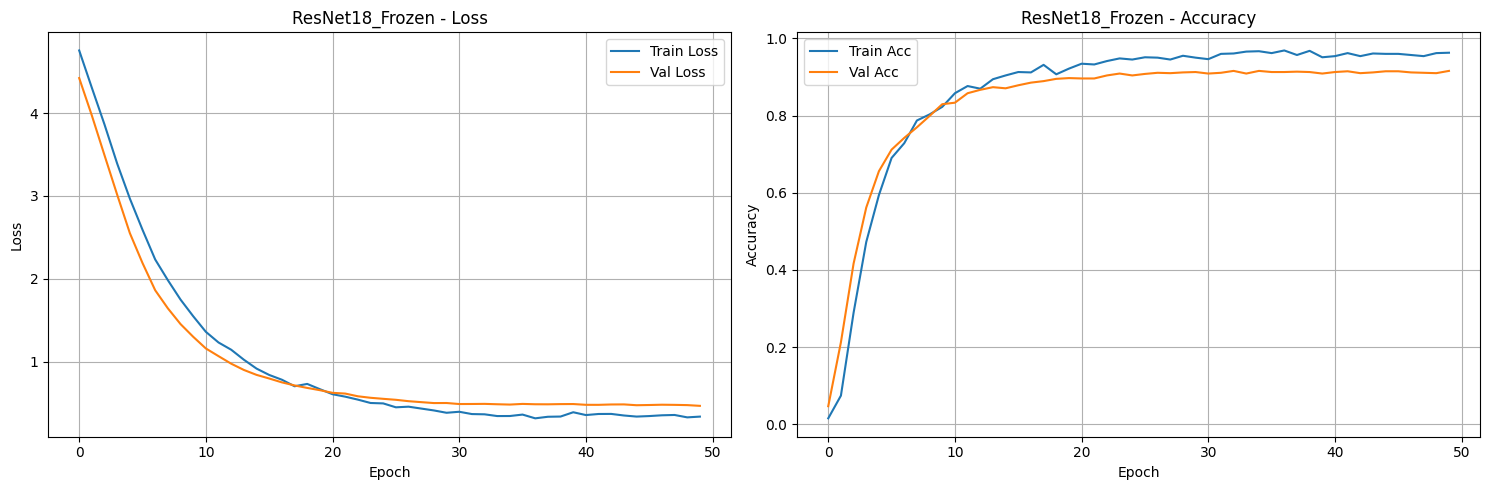

Evaluating on test set...


100%|██████████| 193/193 [00:20<00:00,  9.35it/s]

Test Loss: 0.5767
Test Accuracy: 0.8868
ResNet18 Frozen - Test Accuracy: 0.8868


In [10]:

# Create model with frozen stages
model_frozen = FlowerResNetFrozen(base_model='resnet18', num_frozen_stages=3, num_classes=102)
model_frozen = model_frozen.to(device)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model_frozen.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model_frozen.parameters())
print(f"Trainable parameters: {trainable_params}/{total_params} ({trainable_params/total_params*100:.2f}%)")

# Define optimizer for only trainable parameters
optimizer_ft = optim.SGD(
    filter(lambda p: p.requires_grad, model_frozen.parameters()), 
    lr=0.001, momentum=0.9
)
scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

# Train model
model_frozen, train_losses_f, train_accs_f, val_losses_f, val_accs_f = train_model(
    model_frozen, criterion, optimizer_ft, scheduler_ft, num_epochs, 'resnet18_frozen'
)

# Plot results
plot_training_curves(train_losses_f, val_losses_f, train_accs_f, val_accs_f, 'ResNet18_Frozen')

# Evaluate on test set
test_loss_f, test_acc_f, all_preds_f, all_labels_f = evaluate_model(model_frozen, criterion)

# Save training logs
with open('resnet18_frozen.txt', 'w') as f:
    f.write("Epoch,Train_Loss,Val_Loss,Train_Acc,Val_Acc\n")
    for epoch in range(num_epochs):
        f.write(f"{epoch+1},{train_losses_f[epoch]:.4f},{val_losses_f[epoch]:.4f},{train_accs_f[epoch]:.4f},{val_accs_f[epoch]:.4f}\n")

print(f"ResNet18 Frozen - Test Accuracy: {test_acc_f:.4f}")

### Experiment 3 resnet-34 with 3 frozen stages 

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/UG/rishika004/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 256MB/s]



ResNet34 - Trainable parameters: 19989094/21336998 (93.68%)
Epoch 0/49
----------
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 32/32 [00:11<00:00,  2.82it/s, Loss=4.4086, Acc=0.0714]


train Loss: 4.7367 Acc: 0.0216


Val Epoch 0: 100%|██████████| 32/32 [00:05<00:00,  5.58it/s, Loss=4.3519, Acc=0.1071]



val Loss: 4.3275 Acc: 0.0765
New best model saved with val_acc: 0.0765

Epoch 1/49
----------
New best model saved with val_acc: 0.0765

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s, Loss=3.9253, Acc=0.2143]


train Loss: 4.1263 Acc: 0.1461


Val Epoch 1: 100%|██████████| 32/32 [00:05<00:00,  5.46it/s, Loss=3.6771, Acc=0.5000]



val Loss: 3.7296 Acc: 0.3078
New best model saved with val_acc: 0.3078

Epoch 2/49
----------
New best model saved with val_acc: 0.3078

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 32/32 [00:11<00:00,  2.83it/s, Loss=3.4327, Acc=0.3929]


train Loss: 3.5573 Acc: 0.3922


Val Epoch 2: 100%|██████████| 32/32 [00:06<00:00,  5.18it/s, Loss=2.8522, Acc=0.5714]



val Loss: 3.1110 Acc: 0.5216
New best model saved with val_acc: 0.5216

Epoch 3/49
----------
New best model saved with val_acc: 0.5216

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s, Loss=2.9110, Acc=0.5357]


train Loss: 2.9830 Acc: 0.5706


Val Epoch 3: 100%|██████████| 32/32 [00:05<00:00,  5.41it/s, Loss=2.0972, Acc=0.6786]



val Loss: 2.5573 Acc: 0.6343
New best model saved with val_acc: 0.6343

Epoch 4/49
----------
New best model saved with val_acc: 0.6343

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 32/32 [00:13<00:00,  2.39it/s, Loss=2.2655, Acc=0.7143]


train Loss: 2.5108 Acc: 0.6745


Val Epoch 4: 100%|██████████| 32/32 [00:06<00:00,  5.11it/s, Loss=1.6222, Acc=0.7500]



val Loss: 2.1061 Acc: 0.7088
New best model saved with val_acc: 0.7088

Epoch 5/49
----------
New best model saved with val_acc: 0.7088

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 32/32 [00:11<00:00,  2.87it/s, Loss=2.1510, Acc=0.6429]


train Loss: 2.1006 Acc: 0.7402


Val Epoch 5: 100%|██████████| 32/32 [00:06<00:00,  5.16it/s, Loss=1.3847, Acc=0.7143]



val Loss: 1.7668 Acc: 0.7520
New best model saved with val_acc: 0.7520

Epoch 6/49
----------
New best model saved with val_acc: 0.7520

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s, Loss=1.9463, Acc=0.6786]


train Loss: 1.7943 Acc: 0.7882


Val Epoch 6: 100%|██████████| 32/32 [00:05<00:00,  5.48it/s, Loss=1.0446, Acc=0.8214]



val Loss: 1.4938 Acc: 0.7843
New best model saved with val_acc: 0.7843

Epoch 7/49
----------
New best model saved with val_acc: 0.7843

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 32/32 [00:11<00:00,  2.88it/s, Loss=1.7804, Acc=0.7143]


train Loss: 1.5112 Acc: 0.8392


Val Epoch 7: 100%|██████████| 32/32 [00:05<00:00,  5.52it/s, Loss=0.9478, Acc=0.8571]



val Loss: 1.2856 Acc: 0.8127
New best model saved with val_acc: 0.8127

Epoch 8/49
----------
New best model saved with val_acc: 0.8127

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 32/32 [00:11<00:00,  2.82it/s, Loss=1.1854, Acc=0.8571]


train Loss: 1.2951 Acc: 0.8637


Val Epoch 8: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s, Loss=0.7788, Acc=0.8571]



val Loss: 1.1327 Acc: 0.8412
New best model saved with val_acc: 0.8412

Epoch 9/49
----------
New best model saved with val_acc: 0.8412

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s, Loss=0.9455, Acc=0.8571]


train Loss: 1.1265 Acc: 0.8824


Val Epoch 9: 100%|██████████| 32/32 [00:06<00:00,  5.28it/s, Loss=0.6958, Acc=0.9643]



val Loss: 1.0027 Acc: 0.8588
New best model saved with val_acc: 0.8588

Epoch 10/49
----------
New best model saved with val_acc: 0.8588

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s, Loss=0.8569, Acc=0.9286]


train Loss: 0.9647 Acc: 0.9098


Val Epoch 10: 100%|██████████| 32/32 [00:06<00:00,  5.13it/s, Loss=0.7184, Acc=0.9286]



val Loss: 0.8990 Acc: 0.8676
New best model saved with val_acc: 0.8676

Epoch 11/49
----------
New best model saved with val_acc: 0.8676

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s, Loss=0.8025, Acc=0.8929]


train Loss: 0.8889 Acc: 0.9010


Val Epoch 11: 100%|██████████| 32/32 [00:06<00:00,  5.07it/s, Loss=0.5776, Acc=1.0000]



val Loss: 0.8131 Acc: 0.8735
New best model saved with val_acc: 0.8735

Epoch 12/49
----------
New best model saved with val_acc: 0.8735

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s, Loss=0.8111, Acc=0.9643]


train Loss: 0.7839 Acc: 0.9147


Val Epoch 12: 100%|██████████| 32/32 [00:06<00:00,  4.79it/s, Loss=0.5863, Acc=0.9286]



val Loss: 0.7468 Acc: 0.8765
New best model saved with val_acc: 0.8765

Epoch 13/49
----------
New best model saved with val_acc: 0.8765

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s, Loss=0.6988, Acc=0.8571]


train Loss: 0.7007 Acc: 0.9225


Val Epoch 13: 100%|██████████| 32/32 [00:06<00:00,  5.25it/s, Loss=0.5212, Acc=1.0000]



val Loss: 0.7004 Acc: 0.8902
New best model saved with val_acc: 0.8902

Epoch 14/49
----------
New best model saved with val_acc: 0.8902

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s, Loss=0.5526, Acc=0.9643]


train Loss: 0.6493 Acc: 0.9353


Val Epoch 14: 100%|██████████| 32/32 [00:05<00:00,  5.45it/s, Loss=0.4533, Acc=1.0000]



val Loss: 0.6530 Acc: 0.8990
New best model saved with val_acc: 0.8990

Epoch 15/49
----------
New best model saved with val_acc: 0.8990

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s, Loss=0.7397, Acc=0.9286]


train Loss: 0.5764 Acc: 0.9294


Val Epoch 15: 100%|██████████| 32/32 [00:06<00:00,  4.95it/s, Loss=0.3829, Acc=1.0000]


val Loss: 0.6184 Acc: 0.8961

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s, Loss=0.5510, Acc=0.9286]


train Loss: 0.5184 Acc: 0.9461


Val Epoch 16: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s, Loss=0.3980, Acc=1.0000]


val Loss: 0.5857 Acc: 0.8990

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 32/32 [00:13<00:00,  2.38it/s, Loss=0.7777, Acc=0.8571]


train Loss: 0.5073 Acc: 0.9373


Val Epoch 17: 100%|██████████| 32/32 [00:06<00:00,  4.66it/s, Loss=0.3947, Acc=1.0000]



val Loss: 0.5542 Acc: 0.9059
New best model saved with val_acc: 0.9059

Epoch 18/49
----------
New best model saved with val_acc: 0.9059

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s, Loss=0.2886, Acc=0.9643]


train Loss: 0.4347 Acc: 0.9539


Val Epoch 18: 100%|██████████| 32/32 [00:07<00:00,  4.21it/s, Loss=0.3669, Acc=1.0000]



val Loss: 0.5334 Acc: 0.9069
New best model saved with val_acc: 0.9069

Epoch 19/49
----------
New best model saved with val_acc: 0.9069

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 32/32 [00:13<00:00,  2.34it/s, Loss=0.3709, Acc=0.9643]


train Loss: 0.3791 Acc: 0.9618


Val Epoch 19: 100%|██████████| 32/32 [00:07<00:00,  4.44it/s, Loss=0.3951, Acc=1.0000]



val Loss: 0.5128 Acc: 0.9137
New best model saved with val_acc: 0.9137

Epoch 20/49
----------
New best model saved with val_acc: 0.9137

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 32/32 [00:14<00:00,  2.17it/s, Loss=0.4091, Acc=0.9643]


train Loss: 0.3970 Acc: 0.9539


Val Epoch 20: 100%|██████████| 32/32 [00:19<00:00,  1.67it/s, Loss=0.3201, Acc=1.0000]


val Loss: 0.4954 Acc: 0.9127

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s, Loss=0.3928, Acc=0.9643]


train Loss: 0.4147 Acc: 0.9402


Val Epoch 21: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s, Loss=0.2590, Acc=1.0000]


val Loss: 0.4771 Acc: 0.9118

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 32/32 [00:14<00:00,  2.23it/s, Loss=0.3735, Acc=0.9643]


train Loss: 0.3748 Acc: 0.9578


Val Epoch 22: 100%|██████████| 32/32 [00:07<00:00,  4.39it/s, Loss=0.2262, Acc=1.0000]



val Loss: 0.4734 Acc: 0.9147
New best model saved with val_acc: 0.9147

Epoch 23/49
----------
New best model saved with val_acc: 0.9147

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 32/32 [00:14<00:00,  2.24it/s, Loss=0.1860, Acc=1.0000]


train Loss: 0.3500 Acc: 0.9520


Val Epoch 23: 100%|██████████| 32/32 [00:07<00:00,  4.27it/s, Loss=0.3042, Acc=1.0000]



val Loss: 0.4510 Acc: 0.9206
New best model saved with val_acc: 0.9206

Epoch 24/49
----------
New best model saved with val_acc: 0.9206

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 32/32 [00:13<00:00,  2.31it/s, Loss=0.2547, Acc=1.0000]


train Loss: 0.3320 Acc: 0.9549


Val Epoch 24: 100%|██████████| 32/32 [00:09<00:00,  3.27it/s, Loss=0.2980, Acc=1.0000]



val Loss: 0.4398 Acc: 0.9235
New best model saved with val_acc: 0.9235

Epoch 25/49
----------
New best model saved with val_acc: 0.9235

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 32/32 [00:13<00:00,  2.42it/s, Loss=0.5362, Acc=0.9286]


train Loss: 0.3166 Acc: 0.9598


Val Epoch 25: 100%|██████████| 32/32 [00:07<00:00,  4.43it/s, Loss=0.2829, Acc=1.0000]



val Loss: 0.4313 Acc: 0.9245
New best model saved with val_acc: 0.9245

Epoch 26/49
----------
New best model saved with val_acc: 0.9245

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 32/32 [00:13<00:00,  2.35it/s, Loss=0.2551, Acc=0.9643]


train Loss: 0.2842 Acc: 0.9676


Val Epoch 26: 100%|██████████| 32/32 [00:06<00:00,  4.70it/s, Loss=0.2139, Acc=1.0000]


val Loss: 0.4219 Acc: 0.9235

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 32/32 [00:13<00:00,  2.40it/s, Loss=0.3153, Acc=0.9643]


train Loss: 0.2494 Acc: 0.9706


Val Epoch 27: 100%|██████████| 32/32 [00:05<00:00,  5.50it/s, Loss=0.2030, Acc=1.0000]


val Loss: 0.4135 Acc: 0.9225

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s, Loss=0.1560, Acc=1.0000]


train Loss: 0.2427 Acc: 0.9676


Val Epoch 28: 100%|██████████| 32/32 [00:06<00:00,  5.08it/s, Loss=0.1819, Acc=1.0000]


val Loss: 0.4088 Acc: 0.9225

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 32/32 [00:11<00:00,  2.72it/s, Loss=0.3165, Acc=0.9286]


train Loss: 0.2460 Acc: 0.9686


Val Epoch 29: 100%|██████████| 32/32 [00:06<00:00,  5.04it/s, Loss=0.2178, Acc=1.0000]



val Loss: 0.4028 Acc: 0.9265
New best model saved with val_acc: 0.9265

Epoch 30/49
----------
New best model saved with val_acc: 0.9265

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s, Loss=0.2166, Acc=0.9643]


train Loss: 0.2237 Acc: 0.9735


Val Epoch 30: 100%|██████████| 32/32 [00:06<00:00,  4.91it/s, Loss=0.2181, Acc=1.0000]



val Loss: 0.3938 Acc: 0.9275
New best model saved with val_acc: 0.9275

Epoch 31/49
----------
New best model saved with val_acc: 0.9275

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s, Loss=0.3739, Acc=0.9286]


train Loss: 0.2246 Acc: 0.9735


Val Epoch 31: 100%|██████████| 32/32 [00:06<00:00,  5.08it/s, Loss=0.2165, Acc=1.0000]



val Loss: 0.3917 Acc: 0.9304
New best model saved with val_acc: 0.9304

Epoch 32/49
----------
New best model saved with val_acc: 0.9304

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s, Loss=0.2449, Acc=0.9643]


train Loss: 0.2259 Acc: 0.9765


Val Epoch 32: 100%|██████████| 32/32 [00:06<00:00,  5.10it/s, Loss=0.2182, Acc=1.0000]


val Loss: 0.3972 Acc: 0.9284

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 32/32 [00:12<00:00,  2.57it/s, Loss=0.5282, Acc=0.9286]


train Loss: 0.2530 Acc: 0.9716


Val Epoch 33: 100%|██████████| 32/32 [00:06<00:00,  5.05it/s, Loss=0.2152, Acc=1.0000]


val Loss: 0.3918 Acc: 0.9275

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s, Loss=0.4246, Acc=0.9286]


train Loss: 0.2146 Acc: 0.9775


Val Epoch 34: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s, Loss=0.2238, Acc=1.0000]


val Loss: 0.3920 Acc: 0.9245

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 32/32 [00:13<00:00,  2.32it/s, Loss=0.2680, Acc=1.0000]


train Loss: 0.2433 Acc: 0.9706


Val Epoch 35: 100%|██████████| 32/32 [00:07<00:00,  4.34it/s, Loss=0.2137, Acc=1.0000]


val Loss: 0.3948 Acc: 0.9294

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 32/32 [00:14<00:00,  2.27it/s, Loss=0.1388, Acc=1.0000]


train Loss: 0.2418 Acc: 0.9716


Val Epoch 36: 100%|██████████| 32/32 [00:07<00:00,  4.47it/s, Loss=0.2099, Acc=1.0000]


val Loss: 0.3918 Acc: 0.9284

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 32/32 [00:15<00:00,  2.13it/s, Loss=0.1522, Acc=0.9643]


train Loss: 0.2309 Acc: 0.9647


Val Epoch 37: 100%|██████████| 32/32 [00:07<00:00,  4.45it/s, Loss=0.1909, Acc=1.0000]


val Loss: 0.3912 Acc: 0.9265

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 32/32 [00:13<00:00,  2.29it/s, Loss=0.1455, Acc=1.0000]


train Loss: 0.2565 Acc: 0.9637


Val Epoch 38: 100%|██████████| 32/32 [00:06<00:00,  4.86it/s, Loss=0.1925, Acc=1.0000]


val Loss: 0.3888 Acc: 0.9235

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 32/32 [00:12<00:00,  2.52it/s, Loss=0.1021, Acc=1.0000]


train Loss: 0.1984 Acc: 0.9853


Val Epoch 39: 100%|██████████| 32/32 [00:06<00:00,  4.81it/s, Loss=0.2301, Acc=1.0000]


val Loss: 0.3997 Acc: 0.9284

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s, Loss=0.1916, Acc=0.9643]


train Loss: 0.2518 Acc: 0.9647


Val Epoch 40: 100%|██████████| 32/32 [00:06<00:00,  4.85it/s, Loss=0.2156, Acc=1.0000]


val Loss: 0.3890 Acc: 0.9275

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 32/32 [00:12<00:00,  2.46it/s, Loss=0.4049, Acc=0.8929]


train Loss: 0.2293 Acc: 0.9735


Val Epoch 41: 100%|██████████| 32/32 [00:06<00:00,  5.03it/s, Loss=0.2023, Acc=1.0000]


val Loss: 0.3861 Acc: 0.9245

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s, Loss=0.1558, Acc=1.0000]


train Loss: 0.2315 Acc: 0.9716


Val Epoch 42: 100%|██████████| 32/32 [00:06<00:00,  4.90it/s, Loss=0.1922, Acc=1.0000]


val Loss: 0.3877 Acc: 0.9255

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s, Loss=0.1784, Acc=0.9643]


train Loss: 0.2372 Acc: 0.9706


Val Epoch 43: 100%|██████████| 32/32 [00:06<00:00,  5.21it/s, Loss=0.1947, Acc=1.0000]


val Loss: 0.3903 Acc: 0.9284

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 32/32 [00:16<00:00,  2.00it/s, Loss=0.3426, Acc=0.9643]


train Loss: 0.2179 Acc: 0.9706


Val Epoch 44: 100%|██████████| 32/32 [00:06<00:00,  4.77it/s, Loss=0.1964, Acc=1.0000]


val Loss: 0.3809 Acc: 0.9284

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s, Loss=0.2886, Acc=0.9643]


train Loss: 0.2316 Acc: 0.9686


Val Epoch 45: 100%|██████████| 32/32 [00:07<00:00,  4.36it/s, Loss=0.2037, Acc=1.0000]


val Loss: 0.3815 Acc: 0.9265

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 32/32 [00:14<00:00,  2.20it/s, Loss=0.2651, Acc=0.9643]


train Loss: 0.2113 Acc: 0.9735


Val Epoch 46: 100%|██████████| 32/32 [00:07<00:00,  4.09it/s, Loss=0.2126, Acc=1.0000]


val Loss: 0.3850 Acc: 0.9304

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 32/32 [00:13<00:00,  2.30it/s, Loss=0.2571, Acc=0.9643]


train Loss: 0.2456 Acc: 0.9676


Val Epoch 47: 100%|██████████| 32/32 [00:07<00:00,  4.33it/s, Loss=0.2107, Acc=1.0000]


val Loss: 0.3822 Acc: 0.9304

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s, Loss=0.3086, Acc=0.9643]


train Loss: 0.2408 Acc: 0.9676


Val Epoch 48: 100%|██████████| 32/32 [00:07<00:00,  4.26it/s, Loss=0.1999, Acc=1.0000]



val Loss: 0.3869 Acc: 0.9314
New best model saved with val_acc: 0.9314

Epoch 49/49
----------
New best model saved with val_acc: 0.9314

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 32/32 [00:14<00:00,  2.26it/s, Loss=0.1008, Acc=1.0000]


train Loss: 0.2144 Acc: 0.9716


Val Epoch 49: 100%|██████████| 32/32 [00:06<00:00,  4.81it/s, Loss=0.2037, Acc=1.0000]



val Loss: 0.3839 Acc: 0.9294

Training complete in 17m 7s
Best val Acc: 0.931373


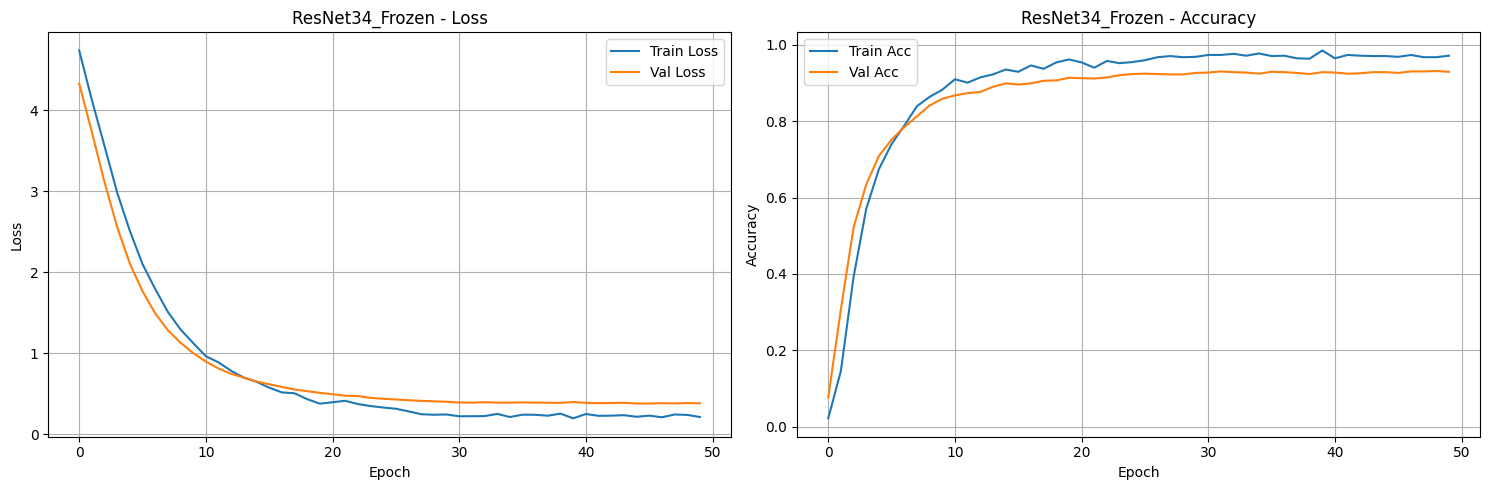

Evaluating on test set...


100%|██████████| 193/193 [00:36<00:00,  5.25it/s]

Test Loss: 0.4596
Test Accuracy: 0.9000
ResNet34 Frozen - Test Accuracy: 0.9000


In [11]:

# Create ResNet-34 model with frozen stages
model_resnet34 = FlowerResNetFrozen(base_model='resnet34', num_frozen_stages=3, num_classes=102)
model_resnet34 = model_resnet34.to(device)

# Count parameters
trainable_params_34 = sum(p.numel() for p in model_resnet34.parameters() if p.requires_grad)
total_params_34 = sum(p.numel() for p in model_resnet34.parameters())
print(f"ResNet34 - Trainable parameters: {trainable_params_34}/{total_params_34} ({trainable_params_34/total_params_34*100:.2f}%)")

# Define optimizer
optimizer_34 = optim.SGD(
    filter(lambda p: p.requires_grad, model_resnet34.parameters()), 
    lr=0.001, momentum=0.9
)
scheduler_34 = lr_scheduler.StepLR(optimizer_34, step_size=30, gamma=0.1)

# Train model
model_resnet34, train_losses_34, train_accs_34, val_losses_34, val_accs_34 = train_model(
    model_resnet34, criterion, optimizer_34, scheduler_34, num_epochs, 'resnet34_frozen'
)

# Plot results
plot_training_curves(train_losses_34, val_losses_34, train_accs_34, val_accs_34, 'ResNet34_Frozen')

# Evaluate on test set
test_loss_34, test_acc_34, all_preds_34, all_labels_34 = evaluate_model(model_resnet34, criterion)

# Save training logs
with open('resnet34_frozen.txt', 'w') as f:
    f.write("Epoch,Train_Loss,Val_Loss,Train_Acc,Val_Acc\n")
    for epoch in range(num_epochs):
        f.write(f"{epoch+1},{train_losses_34[epoch]:.4f},{val_losses_34[epoch]:.4f},{train_accs_34[epoch]:.4f},{val_accs_34[epoch]:.4f}\n")

print(f"ResNet34 Frozen - Test Accuracy: {test_acc_34:.4f}")

### Experiment 4 Resnet-18 with deformable convolutions

In [13]:
class FlowerResNetDeformable(nn.Module):
    def __init__(self, base_model='resnet18', deform_layers=['layer3'], num_classes=102):
        super(FlowerResNetDeformable, self).__init__()
        
        if base_model == 'resnet18':
            self.backbone = models.resnet18(weights='IMAGENET1K_V1')
        else:
            raise ValueError("Only resnet18 supported for deformable version")
        
        # Store original convolutions for reference
        self.original_convs = {}
        
        # Replace regular convolutions with deformable ones in specified layers
        self._replace_with_deformable_conv(deform_layers)
        
        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)
        
    def _replace_with_deformable_conv(self, deform_layers):
        """Replace regular convolutions with deformable convolutions in specified layers"""
        layers_dict = {
            'layer1': self.backbone.layer1,
            'layer2': self.backbone.layer2, 
            'layer3': self.backbone.layer3,
            'layer4': self.backbone.layer4
        }
        
        for layer_name in deform_layers:
            if layer_name in layers_dict:
                layer = layers_dict[layer_name]
                for block_idx, block in enumerate(layer):
                    # Store original parameters
                    if hasattr(block, 'conv1') and block.conv1.kernel_size == (3, 3):
                        in_channels = block.conv1.in_channels
                        out_channels = block.conv1.out_channels
                        stride = block.conv1.stride[0]
                        padding = block.conv1.padding[0]
                        
                        # Create deformable convolution with same parameters
                        deform_conv = DeformableConv2d(
                            in_channels, out_channels, 
                            kernel_size=3, stride=stride, padding=padding
                        )
                        
                        # Copy weights from original convolution
                        deform_conv.conv.weight.data = block.conv1.weight.data.clone()
                        block.conv1 = deform_conv
                        
                    if hasattr(block, 'conv2') and block.conv2.kernel_size == (3, 3):
                        in_channels = block.conv2.in_channels
                        out_channels = block.conv2.out_channels  
                        stride = block.conv2.stride[0]
                        padding = block.conv2.padding[0]
                        
                        # Create deformable convolution with same parameters
                        deform_conv = DeformableConv2d(
                            in_channels, out_channels,
                            kernel_size=3, stride=stride, padding=padding
                        )
                        
                        # Copy weights from original convolution
                        deform_conv.conv.weight.data = block.conv2.weight.data.clone()
                        block.conv2 = deform_conv
    
    def forward(self, x):
        return self.backbone(x)


Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 32/32 [00:59<00:00,  1.87s/it, Loss=4.5682, Acc=0.0000]


train Loss: 4.6860 Acc: 0.0186


Val Epoch 0: 100%|██████████| 32/32 [00:39<00:00,  1.22s/it, Loss=4.3635, Acc=0.0357]



val Loss: 4.3563 Acc: 0.0627
New best model saved with val_acc: 0.0627

Epoch 1/49
----------
New best model saved with val_acc: 0.0627

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 32/32 [00:41<00:00,  1.28s/it, Loss=4.2061, Acc=0.0714]


train Loss: 4.2185 Acc: 0.1118


Val Epoch 1: 100%|██████████| 32/32 [00:21<00:00,  1.46it/s, Loss=3.8539, Acc=0.3571]



val Loss: 3.9072 Acc: 0.2569
New best model saved with val_acc: 0.2569

Epoch 2/49
----------
New best model saved with val_acc: 0.2569

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 32/32 [00:43<00:00,  1.35s/it, Loss=3.7231, Acc=0.2500]


train Loss: 3.7590 Acc: 0.2873


Val Epoch 2: 100%|██████████| 32/32 [00:16<00:00,  1.96it/s, Loss=3.0865, Acc=0.6786]



val Loss: 3.4033 Acc: 0.4265
New best model saved with val_acc: 0.4265

Epoch 3/49
----------
New best model saved with val_acc: 0.4265

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 32/32 [00:47<00:00,  1.49s/it, Loss=3.3175, Acc=0.3571]


train Loss: 3.3035 Acc: 0.4657


Val Epoch 3: 100%|██████████| 32/32 [00:18<00:00,  1.71it/s, Loss=2.4223, Acc=0.8214]



val Loss: 2.8839 Acc: 0.5559
New best model saved with val_acc: 0.5559

Epoch 4/49
----------
New best model saved with val_acc: 0.5559

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it, Loss=2.8781, Acc=0.5000]


train Loss: 2.8542 Acc: 0.5882


Val Epoch 4: 100%|██████████| 32/32 [00:04<00:00,  7.10it/s, Loss=1.9179, Acc=0.8571]



val Loss: 2.4261 Acc: 0.6412
New best model saved with val_acc: 0.6412

Epoch 5/49
----------
New best model saved with val_acc: 0.6412

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s, Loss=2.3292, Acc=0.6429]


train Loss: 2.4627 Acc: 0.6627


Val Epoch 5: 100%|██████████| 32/32 [00:04<00:00,  7.30it/s, Loss=1.4524, Acc=0.8571]



val Loss: 2.1062 Acc: 0.6941
New best model saved with val_acc: 0.6941

Epoch 6/49
----------
New best model saved with val_acc: 0.6941

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s, Loss=2.0917, Acc=0.7500]


train Loss: 2.1456 Acc: 0.7392


Val Epoch 6: 100%|██████████| 32/32 [00:04<00:00,  7.44it/s, Loss=1.0446, Acc=1.0000]



val Loss: 1.8136 Acc: 0.7510
New best model saved with val_acc: 0.7510

Epoch 7/49
----------
New best model saved with val_acc: 0.7510

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 32/32 [00:15<00:00,  2.04it/s, Loss=1.4896, Acc=0.8929]


train Loss: 1.8996 Acc: 0.7627


Val Epoch 7: 100%|██████████| 32/32 [00:04<00:00,  6.48it/s, Loss=0.9722, Acc=0.9286]



val Loss: 1.6182 Acc: 0.7696
New best model saved with val_acc: 0.7696

Epoch 8/49
----------
New best model saved with val_acc: 0.7696

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 32/32 [00:12<00:00,  2.53it/s, Loss=1.5491, Acc=0.8929]


train Loss: 1.6510 Acc: 0.8069


Val Epoch 8: 100%|██████████| 32/32 [00:04<00:00,  7.48it/s, Loss=0.7739, Acc=1.0000]



val Loss: 1.4110 Acc: 0.7990
New best model saved with val_acc: 0.7990

Epoch 9/49
----------
New best model saved with val_acc: 0.7990

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 32/32 [00:12<00:00,  2.47it/s, Loss=1.6894, Acc=0.7857]


train Loss: 1.4970 Acc: 0.8275


Val Epoch 9: 100%|██████████| 32/32 [00:04<00:00,  7.38it/s, Loss=0.6943, Acc=1.0000]



val Loss: 1.2828 Acc: 0.8216
New best model saved with val_acc: 0.8216

Epoch 10/49
----------
New best model saved with val_acc: 0.8216

Epoch 10/49
----------


Train Epoch 10: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s, Loss=1.2609, Acc=0.9286]


train Loss: 1.3112 Acc: 0.8500


Val Epoch 10: 100%|██████████| 32/32 [00:04<00:00,  7.41it/s, Loss=0.6228, Acc=0.9643]



val Loss: 1.1466 Acc: 0.8363
New best model saved with val_acc: 0.8363

Epoch 11/49
----------
New best model saved with val_acc: 0.8363

Epoch 11/49
----------


Train Epoch 11: 100%|██████████| 32/32 [00:12<00:00,  2.58it/s, Loss=1.1678, Acc=0.8929]


train Loss: 1.1819 Acc: 0.8696


Val Epoch 11: 100%|██████████| 32/32 [00:04<00:00,  7.33it/s, Loss=0.5356, Acc=0.9643]



val Loss: 1.0511 Acc: 0.8402
New best model saved with val_acc: 0.8402

Epoch 12/49
----------
New best model saved with val_acc: 0.8402

Epoch 12/49
----------


Train Epoch 12: 100%|██████████| 32/32 [00:12<00:00,  2.48it/s, Loss=1.0632, Acc=0.8571]


train Loss: 1.0893 Acc: 0.8735


Val Epoch 12: 100%|██████████| 32/32 [00:04<00:00,  7.24it/s, Loss=0.5717, Acc=0.9643]



val Loss: 0.9824 Acc: 0.8598
New best model saved with val_acc: 0.8598

Epoch 13/49
----------
New best model saved with val_acc: 0.8598

Epoch 13/49
----------


Train Epoch 13: 100%|██████████| 32/32 [00:11<00:00,  2.85it/s, Loss=1.1863, Acc=0.7857]


train Loss: 1.0016 Acc: 0.8843


Val Epoch 13: 100%|██████████| 32/32 [00:04<00:00,  7.85it/s, Loss=0.5107, Acc=0.9643]


val Loss: 0.8901 Acc: 0.8578

Epoch 14/49
----------


Train Epoch 14: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s, Loss=1.3005, Acc=0.7857]


train Loss: 0.9331 Acc: 0.8882


Val Epoch 14: 100%|██████████| 32/32 [00:04<00:00,  7.08it/s, Loss=0.4602, Acc=0.9643]



val Loss: 0.8407 Acc: 0.8735
New best model saved with val_acc: 0.8735

Epoch 15/49
----------
New best model saved with val_acc: 0.8735

Epoch 15/49
----------


Train Epoch 15: 100%|██████████| 32/32 [00:12<00:00,  2.49it/s, Loss=0.8093, Acc=0.8929]


train Loss: 0.8307 Acc: 0.9127


Val Epoch 15: 100%|██████████| 32/32 [00:04<00:00,  7.39it/s, Loss=0.4079, Acc=0.9643]



val Loss: 0.7972 Acc: 0.8745
New best model saved with val_acc: 0.8745

Epoch 16/49
----------
New best model saved with val_acc: 0.8745

Epoch 16/49
----------


Train Epoch 16: 100%|██████████| 32/32 [00:12<00:00,  2.51it/s, Loss=1.0022, Acc=0.8571]


train Loss: 0.7488 Acc: 0.9265


Val Epoch 16: 100%|██████████| 32/32 [00:04<00:00,  7.73it/s, Loss=0.4108, Acc=0.9643]



val Loss: 0.7533 Acc: 0.8814
New best model saved with val_acc: 0.8814

Epoch 17/49
----------
New best model saved with val_acc: 0.8814

Epoch 17/49
----------


Train Epoch 17: 100%|██████████| 32/32 [00:11<00:00,  2.68it/s, Loss=0.6627, Acc=0.8214]


train Loss: 0.7084 Acc: 0.9098


Val Epoch 17: 100%|██████████| 32/32 [00:04<00:00,  7.63it/s, Loss=0.3866, Acc=0.9643]



val Loss: 0.6993 Acc: 0.8863
New best model saved with val_acc: 0.8863

Epoch 18/49
----------
New best model saved with val_acc: 0.8863

Epoch 18/49
----------


Train Epoch 18: 100%|██████████| 32/32 [00:12<00:00,  2.60it/s, Loss=0.5549, Acc=0.9643]


train Loss: 0.6387 Acc: 0.9363


Val Epoch 18: 100%|██████████| 32/32 [00:04<00:00,  7.74it/s, Loss=0.4073, Acc=0.9643]



val Loss: 0.6898 Acc: 0.8961
New best model saved with val_acc: 0.8961

Epoch 19/49
----------
New best model saved with val_acc: 0.8961

Epoch 19/49
----------


Train Epoch 19: 100%|██████████| 32/32 [00:13<00:00,  2.45it/s, Loss=0.7340, Acc=0.8571]


train Loss: 0.5500 Acc: 0.9529


Val Epoch 19: 100%|██████████| 32/32 [00:04<00:00,  7.55it/s, Loss=0.3664, Acc=0.9643]


val Loss: 0.6572 Acc: 0.8961

Epoch 20/49
----------


Train Epoch 20: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s, Loss=0.5042, Acc=0.9286]


train Loss: 0.5567 Acc: 0.9422


Val Epoch 20: 100%|██████████| 32/32 [00:04<00:00,  7.29it/s, Loss=0.3375, Acc=0.9643]


val Loss: 0.6263 Acc: 0.8961

Epoch 21/49
----------


Train Epoch 21: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s, Loss=0.5508, Acc=0.9286]


train Loss: 0.5405 Acc: 0.9294


Val Epoch 21: 100%|██████████| 32/32 [00:04<00:00,  7.34it/s, Loss=0.4148, Acc=0.9643]



val Loss: 0.6028 Acc: 0.8980
New best model saved with val_acc: 0.8980

Epoch 22/49
----------
New best model saved with val_acc: 0.8980

Epoch 22/49
----------


Train Epoch 22: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s, Loss=0.5601, Acc=0.9643]


train Loss: 0.5347 Acc: 0.9402


Val Epoch 22: 100%|██████████| 32/32 [00:04<00:00,  7.97it/s, Loss=0.3831, Acc=0.9643]



val Loss: 0.5878 Acc: 0.9049
New best model saved with val_acc: 0.9049

Epoch 23/49
----------
New best model saved with val_acc: 0.9049

Epoch 23/49
----------


Train Epoch 23: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s, Loss=0.4044, Acc=0.9643]


train Loss: 0.4910 Acc: 0.9451


Val Epoch 23: 100%|██████████| 32/32 [00:04<00:00,  7.50it/s, Loss=0.3290, Acc=0.9643]



val Loss: 0.5734 Acc: 0.9098
New best model saved with val_acc: 0.9098

Epoch 24/49
----------
New best model saved with val_acc: 0.9098

Epoch 24/49
----------


Train Epoch 24: 100%|██████████| 32/32 [00:12<00:00,  2.61it/s, Loss=0.5047, Acc=0.9286]


train Loss: 0.4874 Acc: 0.9373


Val Epoch 24: 100%|██████████| 32/32 [00:04<00:00,  7.46it/s, Loss=0.2857, Acc=0.9643]


val Loss: 0.5592 Acc: 0.9010

Epoch 25/49
----------


Train Epoch 25: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s, Loss=0.6435, Acc=0.8571]


train Loss: 0.4550 Acc: 0.9402


Val Epoch 25: 100%|██████████| 32/32 [00:04<00:00,  7.42it/s, Loss=0.2703, Acc=0.9643]


val Loss: 0.5416 Acc: 0.9098

Epoch 26/49
----------


Train Epoch 26: 100%|██████████| 32/32 [00:12<00:00,  2.54it/s, Loss=0.3875, Acc=0.9643]


train Loss: 0.4366 Acc: 0.9441


Val Epoch 26: 100%|██████████| 32/32 [00:04<00:00,  7.56it/s, Loss=0.3665, Acc=0.9643]



val Loss: 0.5202 Acc: 0.9108
New best model saved with val_acc: 0.9108

Epoch 27/49
----------
New best model saved with val_acc: 0.9108

Epoch 27/49
----------


Train Epoch 27: 100%|██████████| 32/32 [00:12<00:00,  2.59it/s, Loss=0.4098, Acc=0.9286]


train Loss: 0.3768 Acc: 0.9627


Val Epoch 27: 100%|██████████| 32/32 [00:04<00:00,  7.81it/s, Loss=0.2777, Acc=0.9643]



val Loss: 0.5235 Acc: 0.9176
New best model saved with val_acc: 0.9176

Epoch 28/49
----------
New best model saved with val_acc: 0.9176

Epoch 28/49
----------


Train Epoch 28: 100%|██████████| 32/32 [00:11<00:00,  2.72it/s, Loss=0.3410, Acc=0.9643]


train Loss: 0.3739 Acc: 0.9539


Val Epoch 28: 100%|██████████| 32/32 [00:04<00:00,  7.45it/s, Loss=0.3403, Acc=0.9643]


val Loss: 0.5157 Acc: 0.9176

Epoch 29/49
----------


Train Epoch 29: 100%|██████████| 32/32 [00:12<00:00,  2.55it/s, Loss=0.3348, Acc=0.9643]


train Loss: 0.3900 Acc: 0.9461


Val Epoch 29: 100%|██████████| 32/32 [00:04<00:00,  7.35it/s, Loss=0.3201, Acc=0.9643]


val Loss: 0.4904 Acc: 0.9147

Epoch 30/49
----------


Train Epoch 30: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s, Loss=0.2829, Acc=0.9643]


train Loss: 0.3756 Acc: 0.9559


Val Epoch 30: 100%|██████████| 32/32 [00:04<00:00,  7.36it/s, Loss=0.3089, Acc=0.9643]


val Loss: 0.4965 Acc: 0.9157

Epoch 31/49
----------


Train Epoch 31: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s, Loss=0.4111, Acc=0.9643]


train Loss: 0.3308 Acc: 0.9706


Val Epoch 31: 100%|██████████| 32/32 [00:04<00:00,  6.82it/s, Loss=0.3042, Acc=0.9643]


val Loss: 0.4921 Acc: 0.9157

Epoch 32/49
----------


Train Epoch 32: 100%|██████████| 32/32 [00:11<00:00,  2.71it/s, Loss=0.3053, Acc=1.0000]


train Loss: 0.3795 Acc: 0.9539


Val Epoch 32: 100%|██████████| 32/32 [00:04<00:00,  7.35it/s, Loss=0.2776, Acc=0.9643]


val Loss: 0.4867 Acc: 0.9137

Epoch 33/49
----------


Train Epoch 33: 100%|██████████| 32/32 [00:12<00:00,  2.64it/s, Loss=0.4277, Acc=0.9286]


train Loss: 0.3303 Acc: 0.9637


Val Epoch 33: 100%|██████████| 32/32 [00:04<00:00,  7.15it/s, Loss=0.2949, Acc=0.9643]



val Loss: 0.4948 Acc: 0.9216
New best model saved with val_acc: 0.9216

Epoch 34/49
----------
New best model saved with val_acc: 0.9216

Epoch 34/49
----------


Train Epoch 34: 100%|██████████| 32/32 [00:12<00:00,  2.62it/s, Loss=0.2368, Acc=1.0000]


train Loss: 0.3468 Acc: 0.9627


Val Epoch 34: 100%|██████████| 32/32 [00:04<00:00,  7.41it/s, Loss=0.2882, Acc=0.9643]


val Loss: 0.4918 Acc: 0.9196

Epoch 35/49
----------


Train Epoch 35: 100%|██████████| 32/32 [00:11<00:00,  2.72it/s, Loss=0.4030, Acc=0.9643]


train Loss: 0.3442 Acc: 0.9529


Val Epoch 35: 100%|██████████| 32/32 [00:04<00:00,  7.32it/s, Loss=0.2595, Acc=0.9643]


val Loss: 0.4865 Acc: 0.9186

Epoch 36/49
----------


Train Epoch 36: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s, Loss=0.2296, Acc=1.0000]


train Loss: 0.3438 Acc: 0.9657


Val Epoch 36: 100%|██████████| 32/32 [00:04<00:00,  7.29it/s, Loss=0.2887, Acc=0.9643]


val Loss: 0.4896 Acc: 0.9147

Epoch 37/49
----------


Train Epoch 37: 100%|██████████| 32/32 [00:11<00:00,  2.84it/s, Loss=0.3393, Acc=0.9643]


train Loss: 0.3495 Acc: 0.9520


Val Epoch 37: 100%|██████████| 32/32 [00:04<00:00,  7.29it/s, Loss=0.2483, Acc=0.9643]


val Loss: 0.4810 Acc: 0.9147

Epoch 38/49
----------


Train Epoch 38: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s, Loss=0.4497, Acc=0.8929]


train Loss: 0.3248 Acc: 0.9618


Val Epoch 38: 100%|██████████| 32/32 [00:04<00:00,  7.43it/s, Loss=0.2582, Acc=0.9643]


val Loss: 0.4889 Acc: 0.9127

Epoch 39/49
----------


Train Epoch 39: 100%|██████████| 32/32 [00:11<00:00,  2.86it/s, Loss=0.4123, Acc=0.9643]


train Loss: 0.3468 Acc: 0.9598


Val Epoch 39: 100%|██████████| 32/32 [00:04<00:00,  7.35it/s, Loss=0.2371, Acc=0.9643]


val Loss: 0.4788 Acc: 0.9167

Epoch 40/49
----------


Train Epoch 40: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s, Loss=0.3244, Acc=0.9643]


train Loss: 0.3149 Acc: 0.9676


Val Epoch 40: 100%|██████████| 32/32 [00:04<00:00,  7.52it/s, Loss=0.2458, Acc=0.9643]


val Loss: 0.4782 Acc: 0.9167

Epoch 41/49
----------


Train Epoch 41: 100%|██████████| 32/32 [00:11<00:00,  2.72it/s, Loss=0.3214, Acc=0.9643]


train Loss: 0.3198 Acc: 0.9706


Val Epoch 41: 100%|██████████| 32/32 [00:04<00:00,  7.18it/s, Loss=0.2547, Acc=0.9643]


val Loss: 0.4765 Acc: 0.9196

Epoch 42/49
----------


Train Epoch 42: 100%|██████████| 32/32 [00:11<00:00,  2.90it/s, Loss=0.3525, Acc=0.9643]


train Loss: 0.3129 Acc: 0.9716


Val Epoch 42: 100%|██████████| 32/32 [00:04<00:00,  7.70it/s, Loss=0.2719, Acc=0.9643]


val Loss: 0.4701 Acc: 0.9216

Epoch 43/49
----------


Train Epoch 43: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s, Loss=0.4378, Acc=0.9286]


train Loss: 0.3735 Acc: 0.9520


Val Epoch 43: 100%|██████████| 32/32 [00:04<00:00,  7.19it/s, Loss=0.2518, Acc=0.9643]


val Loss: 0.4732 Acc: 0.9196

Epoch 44/49
----------


Train Epoch 44: 100%|██████████| 32/32 [00:11<00:00,  2.76it/s, Loss=0.2202, Acc=1.0000]


train Loss: 0.3094 Acc: 0.9657


Val Epoch 44: 100%|██████████| 32/32 [00:04<00:00,  7.48it/s, Loss=0.2454, Acc=0.9643]


val Loss: 0.4708 Acc: 0.9176

Epoch 45/49
----------


Train Epoch 45: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s, Loss=0.4190, Acc=0.9643]


train Loss: 0.3441 Acc: 0.9608


Val Epoch 45: 100%|██████████| 32/32 [00:04<00:00,  7.32it/s, Loss=0.2866, Acc=0.9643]


val Loss: 0.4702 Acc: 0.9186

Epoch 46/49
----------


Train Epoch 46: 100%|██████████| 32/32 [00:11<00:00,  2.79it/s, Loss=0.3406, Acc=0.9643]


train Loss: 0.3389 Acc: 0.9608


Val Epoch 46: 100%|██████████| 32/32 [00:04<00:00,  7.11it/s, Loss=0.2675, Acc=0.9643]


val Loss: 0.4745 Acc: 0.9186

Epoch 47/49
----------


Train Epoch 47: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s, Loss=0.3969, Acc=0.9643]


train Loss: 0.3398 Acc: 0.9529


Val Epoch 47: 100%|██████████| 32/32 [00:04<00:00,  7.27it/s, Loss=0.2604, Acc=0.9643]


val Loss: 0.4769 Acc: 0.9157

Epoch 48/49
----------


Train Epoch 48: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s, Loss=0.1575, Acc=1.0000]


train Loss: 0.3103 Acc: 0.9588


Val Epoch 48: 100%|██████████| 32/32 [00:04<00:00,  7.41it/s, Loss=0.2696, Acc=0.9643]


val Loss: 0.4782 Acc: 0.9147

Epoch 49/49
----------


Train Epoch 49: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s, Loss=0.3299, Acc=0.9643]


train Loss: 0.3238 Acc: 0.9676


Val Epoch 49: 100%|██████████| 32/32 [00:04<00:00,  7.33it/s, Loss=0.2827, Acc=0.9643]



val Loss: 0.4800 Acc: 0.9196

Training complete in 18m 1s
Best val Acc: 0.921569


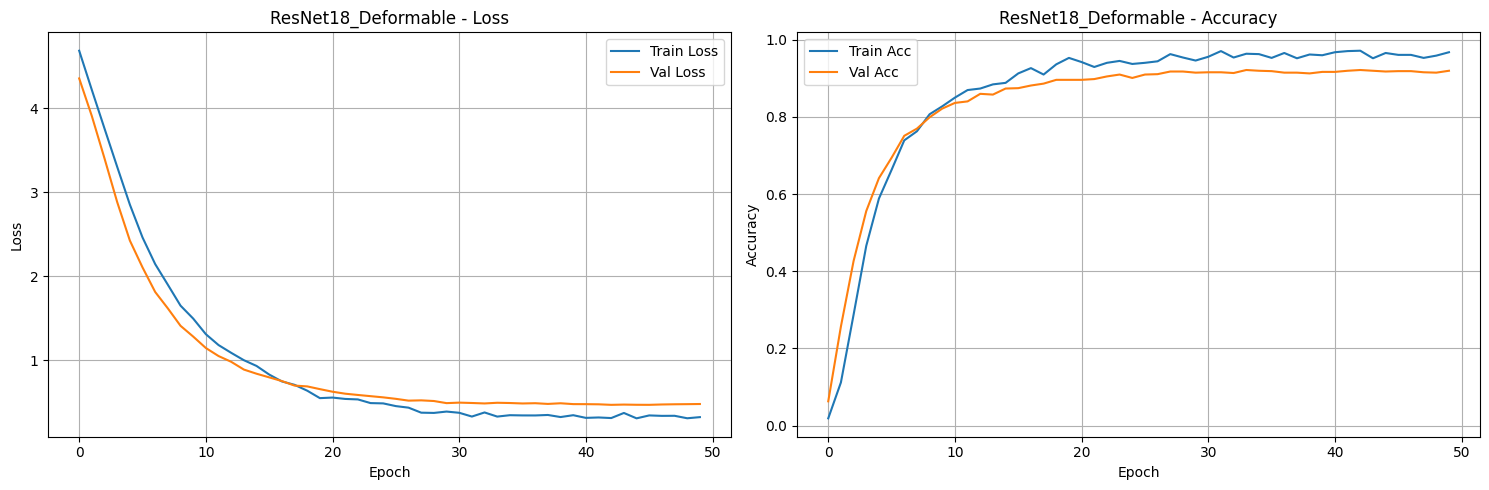

Evaluating on test set...


100%|██████████| 193/193 [00:20<00:00,  9.19it/s]

Test Loss: 0.5938
Test Accuracy: 0.8842
ResNet18 Deformable - Test Accuracy: 0.8842


In [14]:

# Create model with deformable convolutions
model_deform = FlowerResNetDeformable(
    base_model='resnet18', 
    deform_layers=['layer3'], 
    num_classes=102
)
model_deform = model_deform.to(device)

# Define optimizer
optimizer_deform = optim.SGD(model_deform.parameters(), lr=0.001, momentum=0.9)
scheduler_deform = lr_scheduler.StepLR(optimizer_deform, step_size=30, gamma=0.1)

# Train model
model_deform, train_losses_d, train_accs_d, val_losses_d, val_accs_d = train_model(
    model_deform, criterion, optimizer_deform, scheduler_deform, num_epochs, 'resnet18_deformable'
)

# Plot results
plot_training_curves(train_losses_d, val_losses_d, train_accs_d, val_accs_d, 'ResNet18_Deformable')

# Evaluate on test set
test_loss_d, test_acc_d, all_preds_d, all_labels_d = evaluate_model(model_deform, criterion)

# Save training logs
with open('resnet18_deformable.txt', 'w') as f:
    f.write("Epoch,Train_Loss,Val_Loss,Train_Acc,Val_Acc\n")
    for epoch in range(num_epochs):
        f.write(f"{epoch+1},{train_losses_d[epoch]:.4f},{val_losses_d[epoch]:.4f},{train_accs_d[epoch]:.4f},{val_accs_d[epoch]:.4f}\n")

print(f"ResNet18 Deformable - Test Accuracy: {test_acc_d:.4f}")

In [16]:
class DeformableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DeformableConv2d, self).__init__()
        
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # Offset convolution - generates 2*kernel_size*kernel_size offsets (x,y for each kernel position)
        self.offset_conv = nn.Conv2d(
            in_channels, 
            2 * kernel_size * kernel_size,  # 2 offsets (x,y) for each kernel position
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding
        )
        
        # Regular convolution for the actual features
        self.conv = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=kernel_size, 
            stride=stride, 
            padding=padding
        )
        
        # Initialize offset weights to zero for stable training start
        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)
        
    def forward(self, x):
        # Generate offsets [batch, 2*K*K, H, W]
        offsets = self.offset_conv(x)
        
        # Use torchvision's deform_conv2d if available
        try:
            from torchvision.ops import deform_conv2d
            return deform_conv2d(
                x, 
                offsets, 
                self.conv.weight, 
                self.conv.bias,
                stride=(self.stride, self.stride),
                padding=(self.padding, self.padding)
            )
        except ImportError:
            # Fallback implementation - apply regular convolution but at least use the offsets in some way
            # This is a simplified version - in practice you'd implement proper sampling
            print("Warning: torchvision.ops.deform_conv2d not available, using regular convolution")
            return self.conv(x)

class FlowerResNetDeformable(nn.Module):
    def __init__(self, base_model='resnet18', deform_layers=['layer3'], num_classes=102):
        super(FlowerResNetDeformable, self).__init__()
        
        if base_model == 'resnet18':
            self.backbone = models.resnet18(weights='IMAGENET1K_V1')
        else:
            raise ValueError("Only resnet18 supported for deformable version")
        
        # Replace regular convolutions with deformable ones in specified layers
        self._replace_with_deformable_conv(deform_layers)
        
        # Replace the final fully connected layer
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)
        
    def _replace_with_deformable_conv(self, deform_layers):
        """Replace regular convolutions with deformable convolutions in specified layers"""
        layers_dict = {
            'layer1': self.backbone.layer1,
            'layer2': self.backbone.layer2, 
            'layer3': self.backbone.layer3,
            'layer4': self.backbone.layer4
        }
        
        for layer_name in deform_layers:
            if layer_name in layers_dict:
                layer = layers_dict[layer_name]
                for block_idx, block in enumerate(layer):
                    # Store original parameters and replace conv1
                    if hasattr(block, 'conv1') and block.conv1.kernel_size == (3, 3):
                        in_channels = block.conv1.in_channels
                        out_channels = block.conv1.out_channels
                        stride = block.conv1.stride[0]
                        padding = block.conv1.padding[0]
                        bias = block.conv1.bias is not None
                        
                        # Create deformable convolution with same parameters
                        deform_conv = DeformableConv2d(
                            in_channels, out_channels, 
                            kernel_size=3, stride=stride, padding=padding
                        )
                        
                        # Copy weights and bias from original convolution
                        deform_conv.conv.weight.data = block.conv1.weight.data.clone()
                        if bias and deform_conv.conv.bias is not None:
                            deform_conv.conv.bias.data = block.conv1.bias.data.clone()
                        
                        block.conv1 = deform_conv
                        
                    # Store original parameters and replace conv2  
                    if hasattr(block, 'conv2') and block.conv2.kernel_size == (3, 3):
                        in_channels = block.conv2.in_channels
                        out_channels = block.conv2.out_channels  
                        stride = block.conv2.stride[0]
                        padding = block.conv2.padding[0]
                        bias = block.conv2.bias is not None
                        
                        # Create deformable convolution with same parameters
                        deform_conv = DeformableConv2d(
                            in_channels, out_channels,
                            kernel_size=3, stride=stride, padding=padding
                        )
                        
                        # Copy weights and bias from original convolution
                        deform_conv.conv.weight.data = block.conv2.weight.data.clone()
                        if bias and deform_conv.conv.bias is not None:
                            deform_conv.conv.bias.data = block.conv2.bias.data.clone()
                        
                        block.conv2 = deform_conv
    
    def forward(self, x):
        return self.backbone(x)

In [ ]:

# Create model with deformable convolutions
model_deform = FlowerResNetDeformable(
    base_model='resnet18', 
    deform_layers=['layer3'], 
    num_classes=102
)
model_deform = model_deform.to(device)

# Print model info to verify deformable convolutions are there
print("Deformable model created. Checking layers...")
for name, module in model_deform.named_modules():
    if 'deform' in name.lower() or 'offset' in name.lower():
        print(f"Found deformable layer: {name}")

# Define optimizer
optimizer_deform = optim.SGD(model_deform.parameters(), lr=0.001, momentum=0.9)
scheduler_deform = lr_scheduler.StepLR(optimizer_deform, step_size=30, gamma=0.1)

# Train model
model_deform, train_losses_d, train_accs_d, val_losses_d, val_accs_d = train_model(
    model_deform, criterion, optimizer_deform, scheduler_deform, num_epochs, 'resnet18_deformable'
)

# Plot results
plot_training_curves(train_losses_d, val_losses_d, train_accs_d, val_accs_d, 'ResNet18_Deformable')

# Evaluate on test set
test_loss_d, test_acc_d, all_preds_d, all_labels_d = evaluate_model(model_deform, criterion)

# Save training logs
with open('resnet18_deformable.txt', 'w') as f:
    f.write("Epoch,Train_Loss,Val_Loss,Train_Acc,Val_Acc\n")
    for epoch in range(num_epochs):
        f.write(f"{epoch+1},{train_losses_d[epoch]:.4f},{val_losses_d[epoch]:.4f},{train_accs_d[epoch]:.4f},{val_accs_d[epoch]:.4f}\n")

print(f"ResNet18 Deformable - Test Accuracy: {test_acc_d:.4f}")


Deformable model created. Checking layers...
Found deformable layer: backbone.layer3.0.conv1.offset_conv
Found deformable layer: backbone.layer3.0.conv2.offset_conv
Found deformable layer: backbone.layer3.1.conv1.offset_conv
Found deformable layer: backbone.layer3.1.conv2.offset_conv
Epoch 0/49
----------
Epoch 0/49
----------


Train Epoch 0: 100%|██████████| 32/32 [04:55<00:00,  9.24s/it, Loss=4.5432, Acc=0.0000]


train Loss: 4.7004 Acc: 0.0147


Val Epoch 0: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, Loss=4.0753, Acc=0.1786]



val Loss: 4.3895 Acc: 0.0529
New best model saved with val_acc: 0.0529

Epoch 1/49
----------
New best model saved with val_acc: 0.0529

Epoch 1/49
----------


Train Epoch 1: 100%|██████████| 32/32 [04:53<00:00,  9.18s/it, Loss=4.2173, Acc=0.1071]


train Loss: 4.2111 Acc: 0.1059


Val Epoch 1: 100%|██████████| 32/32 [00:36<00:00,  1.14s/it, Loss=3.7008, Acc=0.3214]



val Loss: 3.9155 Acc: 0.2333
New best model saved with val_acc: 0.2333

Epoch 2/49
----------
New best model saved with val_acc: 0.2333

Epoch 2/49
----------


Train Epoch 2: 100%|██████████| 32/32 [04:57<00:00,  9.31s/it, Loss=3.8707, Acc=0.2143]


train Loss: 3.7612 Acc: 0.3088


Val Epoch 2: 100%|██████████| 32/32 [00:36<00:00,  1.15s/it, Loss=2.8460, Acc=0.7857]



val Loss: 3.4150 Acc: 0.4147
New best model saved with val_acc: 0.4147

Epoch 3/49
----------
New best model saved with val_acc: 0.4147

Epoch 3/49
----------


Train Epoch 3: 100%|██████████| 32/32 [05:05<00:00,  9.55s/it, Loss=3.0736, Acc=0.5357]


train Loss: 3.2879 Acc: 0.4804


Val Epoch 3: 100%|██████████| 32/32 [00:37<00:00,  1.16s/it, Loss=2.2749, Acc=0.7143]



val Loss: 2.8928 Acc: 0.5353
New best model saved with val_acc: 0.5353

Epoch 4/49
----------
New best model saved with val_acc: 0.5353

Epoch 4/49
----------


Train Epoch 4: 100%|██████████| 32/32 [04:59<00:00,  9.36s/it, Loss=2.8089, Acc=0.5714]


train Loss: 2.8512 Acc: 0.5922


Val Epoch 4: 100%|██████████| 32/32 [00:36<00:00,  1.14s/it, Loss=1.5568, Acc=0.8571]



val Loss: 2.4419 Acc: 0.6118
New best model saved with val_acc: 0.6118

Epoch 5/49
----------
New best model saved with val_acc: 0.6118

Epoch 5/49
----------


Train Epoch 5: 100%|██████████| 32/32 [04:49<00:00,  9.04s/it, Loss=2.5377, Acc=0.4643]


train Loss: 2.4861 Acc: 0.6598


Val Epoch 5: 100%|██████████| 32/32 [00:35<00:00,  1.11s/it, Loss=1.2136, Acc=0.9286]



val Loss: 2.1037 Acc: 0.6696
New best model saved with val_acc: 0.6696

Epoch 6/49
----------
New best model saved with val_acc: 0.6696

Epoch 6/49
----------


Train Epoch 6: 100%|██████████| 32/32 [04:56<00:00,  9.26s/it, Loss=2.3785, Acc=0.5714]


train Loss: 2.1627 Acc: 0.7147


Val Epoch 6: 100%|██████████| 32/32 [00:35<00:00,  1.12s/it, Loss=1.1641, Acc=0.9286]



val Loss: 1.8467 Acc: 0.7088
New best model saved with val_acc: 0.7088

Epoch 7/49
----------
New best model saved with val_acc: 0.7088

Epoch 7/49
----------


Train Epoch 7: 100%|██████████| 32/32 [04:47<00:00,  8.98s/it, Loss=1.9208, Acc=0.7857]


train Loss: 1.9419 Acc: 0.7461


Val Epoch 7: 100%|██████████| 32/32 [00:35<00:00,  1.11s/it, Loss=1.0767, Acc=0.9286]



val Loss: 1.6306 Acc: 0.7353
New best model saved with val_acc: 0.7353

Epoch 8/49
----------
New best model saved with val_acc: 0.7353

Epoch 8/49
----------


Train Epoch 8: 100%|██████████| 32/32 [04:52<00:00,  9.14s/it, Loss=1.9001, Acc=0.6786]


train Loss: 1.6600 Acc: 0.8127


Val Epoch 8: 100%|██████████| 32/32 [00:36<00:00,  1.14s/it, Loss=0.8574, Acc=0.9286]



val Loss: 1.4729 Acc: 0.7765
New best model saved with val_acc: 0.7765

Epoch 9/49
----------
New best model saved with val_acc: 0.7765

Epoch 9/49
----------


Train Epoch 9: 100%|██████████| 32/32 [05:00<00:00,  9.38s/it, Loss=1.5883, Acc=0.7857]


train Loss: 1.4988 Acc: 0.8069


Val Epoch 9: 100%|██████████| 32/32 [00:36<00:00,  1.13s/it, Loss=0.8411, Acc=0.9286]



val Loss: 1.3319 Acc: 0.7941
New best model saved with val_acc: 0.7941

Epoch 10/49
----------
New best model saved with val_acc: 0.7941

Epoch 10/49
----------


Train Epoch 10:  84%|████████▍ | 27/32 [04:12<00:46,  9.34s/it, Loss=1.1750, Acc=0.9062]

In [ ]:
# Compare all experiments
def compare_experiments():
    experiments = {
        'ResNet18 Original': 'resnet18_original.txt',
        'ResNet18 Frozen': 'resnet18_frozen.txt', 
        'ResNet34 Frozen': 'resnet34_frozen.txt',
        'ResNet18 Deformable': 'resnet18_deformable.txt'
    }
    
    plt.figure(figsize=(15, 6))
    
    # Plot validation accuracy comparison
    plt.subplot(1, 2, 1)
    for exp_name, file_path in experiments.items():
        try:
            data = pd.read_csv(file_path)
            plt.plot(data['Val_Acc'], label=exp_name, linewidth=2)
        except FileNotFoundError:
            print(f"File {file_path} not found")
            continue
    
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot validation loss comparison
    plt.subplot(1, 2, 2)
    for exp_name, file_path in experiments.items():
        try:
            data = pd.read_csv(file_path)
            plt.plot(data['Val_Loss'], label=exp_name, linewidth=2)
        except FileNotFoundError:
            continue
    
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('all_experiments_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Compare experiments
compare_experiments()

# Visualize predictions from the best model
print("Visualizing predictions from ResNet18 Original:")
visualize_model_predictions(model_resnet18)

# Create summary table
results_summary = {
    'Model': ['ResNet18 Original', 'ResNet18 Frozen', 'ResNet34 Frozen', 'ResNet18 Deformable'],
    'Test Accuracy': [float(test_acc), float(test_acc_f), float(test_acc_34), float(test_acc_d)],
    'Best Val Accuracy': [max(val_accs), max(val_accs_f), max(val_accs_34), max(val_accs_d)]
}

results_df = pd.DataFrame(results_summary)
print("\n=== Results Summary ===")
print(results_df.to_string(index=False))

# Save results to CSV
results_df.to_csv('experiment_results.csv', index=False)

In [ ]:
# Confusion matrix for the best model
print("Generating confusion matrix for ResNet18 Original...")
plot_confusion_matrix(all_labels, all_preds)

# Class-wise accuracy
def calculate_class_accuracy(all_labels, all_preds, num_classes=102):
    class_correct = [0] * num_classes
    class_total = [0] * num_classes
    
    for i in range(len(all_labels)):
        label = all_labels[i]
        pred = all_preds[i]
        class_total[label] += 1
        if label == pred:
            class_correct[label] += 1
    
    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 
                     for i in range(num_classes)]
    
    return class_accuracy

class_accuracy = calculate_class_accuracy(all_labels, all_preds)

# Plot class-wise accuracy
plt.figure(figsize=(15, 6))
plt.bar(range(102), class_accuracy)
plt.title('Class-wise Accuracy')
plt.xlabel('Class ID')
plt.ylabel('Accuracy')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('class_wise_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# Print worst performing classes
class_acc_df = pd.DataFrame({
    'Class': range(102),
    'Accuracy': class_accuracy,
    'Samples': [sum(1 for x in all_labels if x == i) for i in range(102)]
})

print("\nTop 10 worst performing classes:")
print(class_acc_df.nsmallest(10, 'Accuracy')[['Class', 'Accuracy', 'Samples']].to_string(index=False))

print("\nTop 10 best performing classes:")
print(class_acc_df.nlargest(10, 'Accuracy')[['Class', 'Accuracy', 'Samples']].to_string(index=False))